## Data Source

* The data source is the file `train.csv`.
* These are 32x32 pixel grayscale images obtained from the [Fashion MNIST dataset](https://www.kaggle.com/datasets/zalando-research/fashionmnist).
* The file `train.csv` contains the training data.
* The target (explained) variable is named **label**.

## Project Content

* In the notebook, we will load the data from the file `train.csv`. We will appropriately split the data into subsets for training, model comparison, and subsequent prediction of the final model's performance.

* Perform a basic exploration of the data and display some of the images.

* Construct and train several variations of a feedforward neural network model. Doing so within computational capabilities:
    * Experiment with different depths and layer sizes.
    * Experiment with data standardization/normalization.
    * Experiment with different optimization methods.
    * Experiment with different regularization techniques.

* Construct a convolutional neural network model. Within the limits of computational capability:
    * Experiment with different depths and layer sizes.
    * Experiment with data standardization/normalization.
    * Experiment with different optimization methods.
    * Experiment with different regularization techniques.

* From all the options tested, select the final model and estimate the expected accuracy on new data that we have not yet had access to.

In [122]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

import sklearn.metrics as metrics

import optuna
from optuna.trial import TrialState
from optuna.samplers import TPESampler
from optuna.visualization.matplotlib import plot_param_importances

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [123]:
# 1. Define seed value
random_seed = 5162020

# 2. Set `pytorch` random seed 
torch.manual_seed(random_seed)

# 3. Use `optuna` sampler with predefined seed 
sampler = TPESampler(seed=random_seed)

# 4. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(random_seed)
# 5. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(random_seed)
# 6. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(random_seed)

In [124]:
# Constants used in optuna
DEVICE = torch.device("cpu")
BATCHSIZE = 128
CLASSES = 10
EPOCHS = 30

## Data Collection 

In [125]:
data = pd.read_csv("train.csv")
data

pix1  pix2  pix3  pix4  pix5  pix6  pix7  pix8  pix9  pix10  ...  \
0         0     0     0     0     0     0     0     0     0      0  ...   
1         1     1     1     1     1     1     1     1     1      1  ...   
2         1     1     1     1     1     1     1     1     1      1  ...   
3         0     0     0     0     0     0     0     0     0      0  ...   
4         1     1     1     1     1     1     1     1     1      1  ...   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...    ...  ...   
52495     0     0     0     0     0     0     0     0     0      0  ...   
52496     1     1     1     1     1     1     1     1     1      1  ...   
52497     0     0     0     0     0     0     0     0     0      0  ...   
52498     0     0     0     0     0     0     0     0     0      0  ...   
52499     4     4     4     4     4     4     4     4     4      4  ...   

       pix1016  pix1017  pix1018  pix1019  pix1020  pix1021  pix1022  pix1023  \
0            0        0        0        0        0        0        0        0   
1            1        1        1        1        1        1        1        1   
2            1        1        1        1        1        1        1        1   
3            0        0        0        0        0        0        0        0   
4            1        1        1        1        1        1        1        1   
...        ...      ...      ...      ...      ...      ...      ...      ...   
52495        0        0        0        0        0        0        0        0   
52496        1        1        1        1        1        1        1        1   
52497        0        0        0        0        0        0        0        0   
52498        0        0        0        0        0        0        0        0   
52499        4        4        4        4        4        4        4        4   

       pix1024  label  
0            0      3  
1            1      3  
2            1      7  
3            0      9  
4            1      5  
...        ...    ...  
52495        0      3  
52496        1      1  
52497        0      9  
52498        0      6  
52499        4      3  

[52500 rows x 1025 columns]

Description of dataset from Kaggle:

### About Dataset

#### Context
- Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

#### Content
- Each image is **28 pixels in height and 28 pixels in width**[^1], for a total of **784 pixels in total**. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between **0 and 255**[^2]. The training and test data sets have **785 columns**. The first column consists of the class labels (see above), and represents the article of clothing. The rest of the columns contain the pixel-values of the associated image.

- To locate a pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27. The pixel is located on row i and column j of a 28 x 28 matrix[^3].
- For example, **pixel31** indicates the pixel that is in the **fourth column** from the left, and the **second row** from the top.


#### Labels

Each training and test example is assigned to one of the following labels:

* 0 T-shirt/top
* 1 Trouser
* 2 Pullover
* 3 Dress
* 4 Coat
* 5 Sandal
* 6 Shirt
* 7 Sneaker
* 8 Bag
* 9 Ankle boot


TL;DR

- Each row is a separate image
- Column 1 is the class label.
- Remaining columns are pixel numbers (784 total).
- Each value is the darkness of the pixel (0 to 255)

[^1]: *According to the task specification we have 32x32 pixel images in grayscale*

[^2]: *(author's notes: apparently value scales from 0 to 255 where 0 is black and 255 is white)*

[^3]: *(author's notes: apparently the bounds for j are incorrectly specified. There is no pixel0 in the dataset, and if i and j take values from 0 to 27, the total number of pixels is 27\*28+27 = 783. In this work I assume that j takes values from 1 to 28)*

###
Let's see some basic information available:

In [126]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52500 entries, 0 to 52499
Data columns (total 1025 columns):
 #     Column   Dtype
---    ------   -----
 0     pix1     int64
 1     pix2     int64
 2     pix3     int64
 3     pix4     int64
 4     pix5     int64
 5     pix6     int64
 6     pix7     int64
 7     pix8     int64
 8     pix9     int64
 9     pix10    int64
 10    pix11    int64
 11    pix12    int64
 12    pix13    int64
 13    pix14    int64
 14    pix15    int64
 15    pix16    int64
 16    pix17    int64
 17    pix18    int64
 18    pix19    int64
 19    pix20    int64
 20    pix21    int64
 21    pix22    int64
 22    pix23    int64
 23    pix24    int64
 24    pix25    int64
 25    pix26    int64
 26    pix27    int64
 27    pix28    int64
 28    pix29    int64
 29    pix30    int64
 30    pix31    int64
 31    pix32    int64
 32    pix33    int64
 33    pix34    int64
 34    pix35    int64
 35    pix36    int64
 36    pix37    int64
 37    pix38    int64
 38    pi

In [127]:
data.describe()

pix1          pix2          pix3          pix4          pix5  \
count  52500.000000  52500.000000  52500.000000  52500.000000  52500.000000   
mean       0.877390      0.877390      0.877390      0.877390      0.877410   
std        1.493605      1.493605      1.493605      1.493605      1.493601   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        1.000000      1.000000      1.000000      1.000000      1.000000   
max       11.000000     11.000000     11.000000     11.000000     11.000000   

               pix6          pix7          pix8          pix9         pix10  \
count  52500.000000  52500.000000  52500.000000  52500.000000  52500.000000   
mean       0.877429      0.877429      0.877543      0.878038      0.880648   
std        1.493596      1.493596      1.493682      1.494258      1.528912   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        1.000000      1.000000      1.000000      1.000000      1.000000   
max       11.000000     11.000000     11.000000     11.000000     73.000000   

       ...       pix1016       pix1017       pix1018       pix1019  \
count  ...  52500.000000  52500.000000  52500.000000  52500.000000   
mean   ...      0.929867      0.909143      0.893524      0.883505   
std    ...      2.835341      2.224631      1.794160      1.615415   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      0.000000      0.000000      0.000000      0.000000   
75%    ...      1.000000      1.000000      1.000000      1.000000   
max    ...    187.000000    172.000000    134.000000    116.000000   

            pix1020       pix1021       pix1022       pix1023       pix1024  \
count  52500.000000  52500.000000  52500.000000  52500.000000  52500.000000   
mean       0.878952      0.877467      0.877410      0.877390      0.877390   
std        1.505722      1.493854      1.493677      1.493605      1.493605   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        1.000000      1.000000      1.000000      1.000000      1.000000   
max       41.000000     11.000000     11.000000     11.000000     11.000000   

              label  
count  52500.000000  
mean       4.509752  
std        2.872106  
min        0.000000  
25%        2.000000  
50%        5.000000  
75%        7.000000  
max        9.000000  

[8 rows x 1025 columns]

- Here we can see that maximum value of target **label** is 9 and minimum is 0, which **does corresponds** with description from Kaggle.
- Pixels on the edge (for example, **pixel1, pixel2** and **pixel3**) does not have value 0 for all pictures. Therefore they **can have impact** on target.

## Data Split

In [128]:
# Split ratio: 60% train, 20% validation, 20% test

Xtrain, Xrest, ytrain, yrest = train_test_split( 
      data.drop(columns=['label']), 
      data['label'], 
      test_size=0.4, 
      random_state=random_seed
)

Xval, Xtest, yval, ytest = train_test_split( 
      Xrest, 
      yrest, 
      test_size=0.5, 
      random_state=random_seed
)
print(Xtrain.shape)
print(Xval.shape)
print(Xtest.shape)

(31500, 1024)
(10500, 1024)
(10500, 1024)


## Data Exploration

First of all lets make sure we dont have missing values:

In [129]:
missing_values = Xtrain.isna().any().any()
non_integer_values = Xtrain.applymap(lambda x: not isinstance(x, int)).any().any()
print(f"Presence of missing values: {missing_values and non_integer_values}")

Presence of missing values: False


Let's observe how many unique labels we have:

In [130]:
np.sort(ytrain.unique())

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

The number of unique values matches the description:

In [131]:
# Define label names
label_names = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

To be sure, let's look at the images:

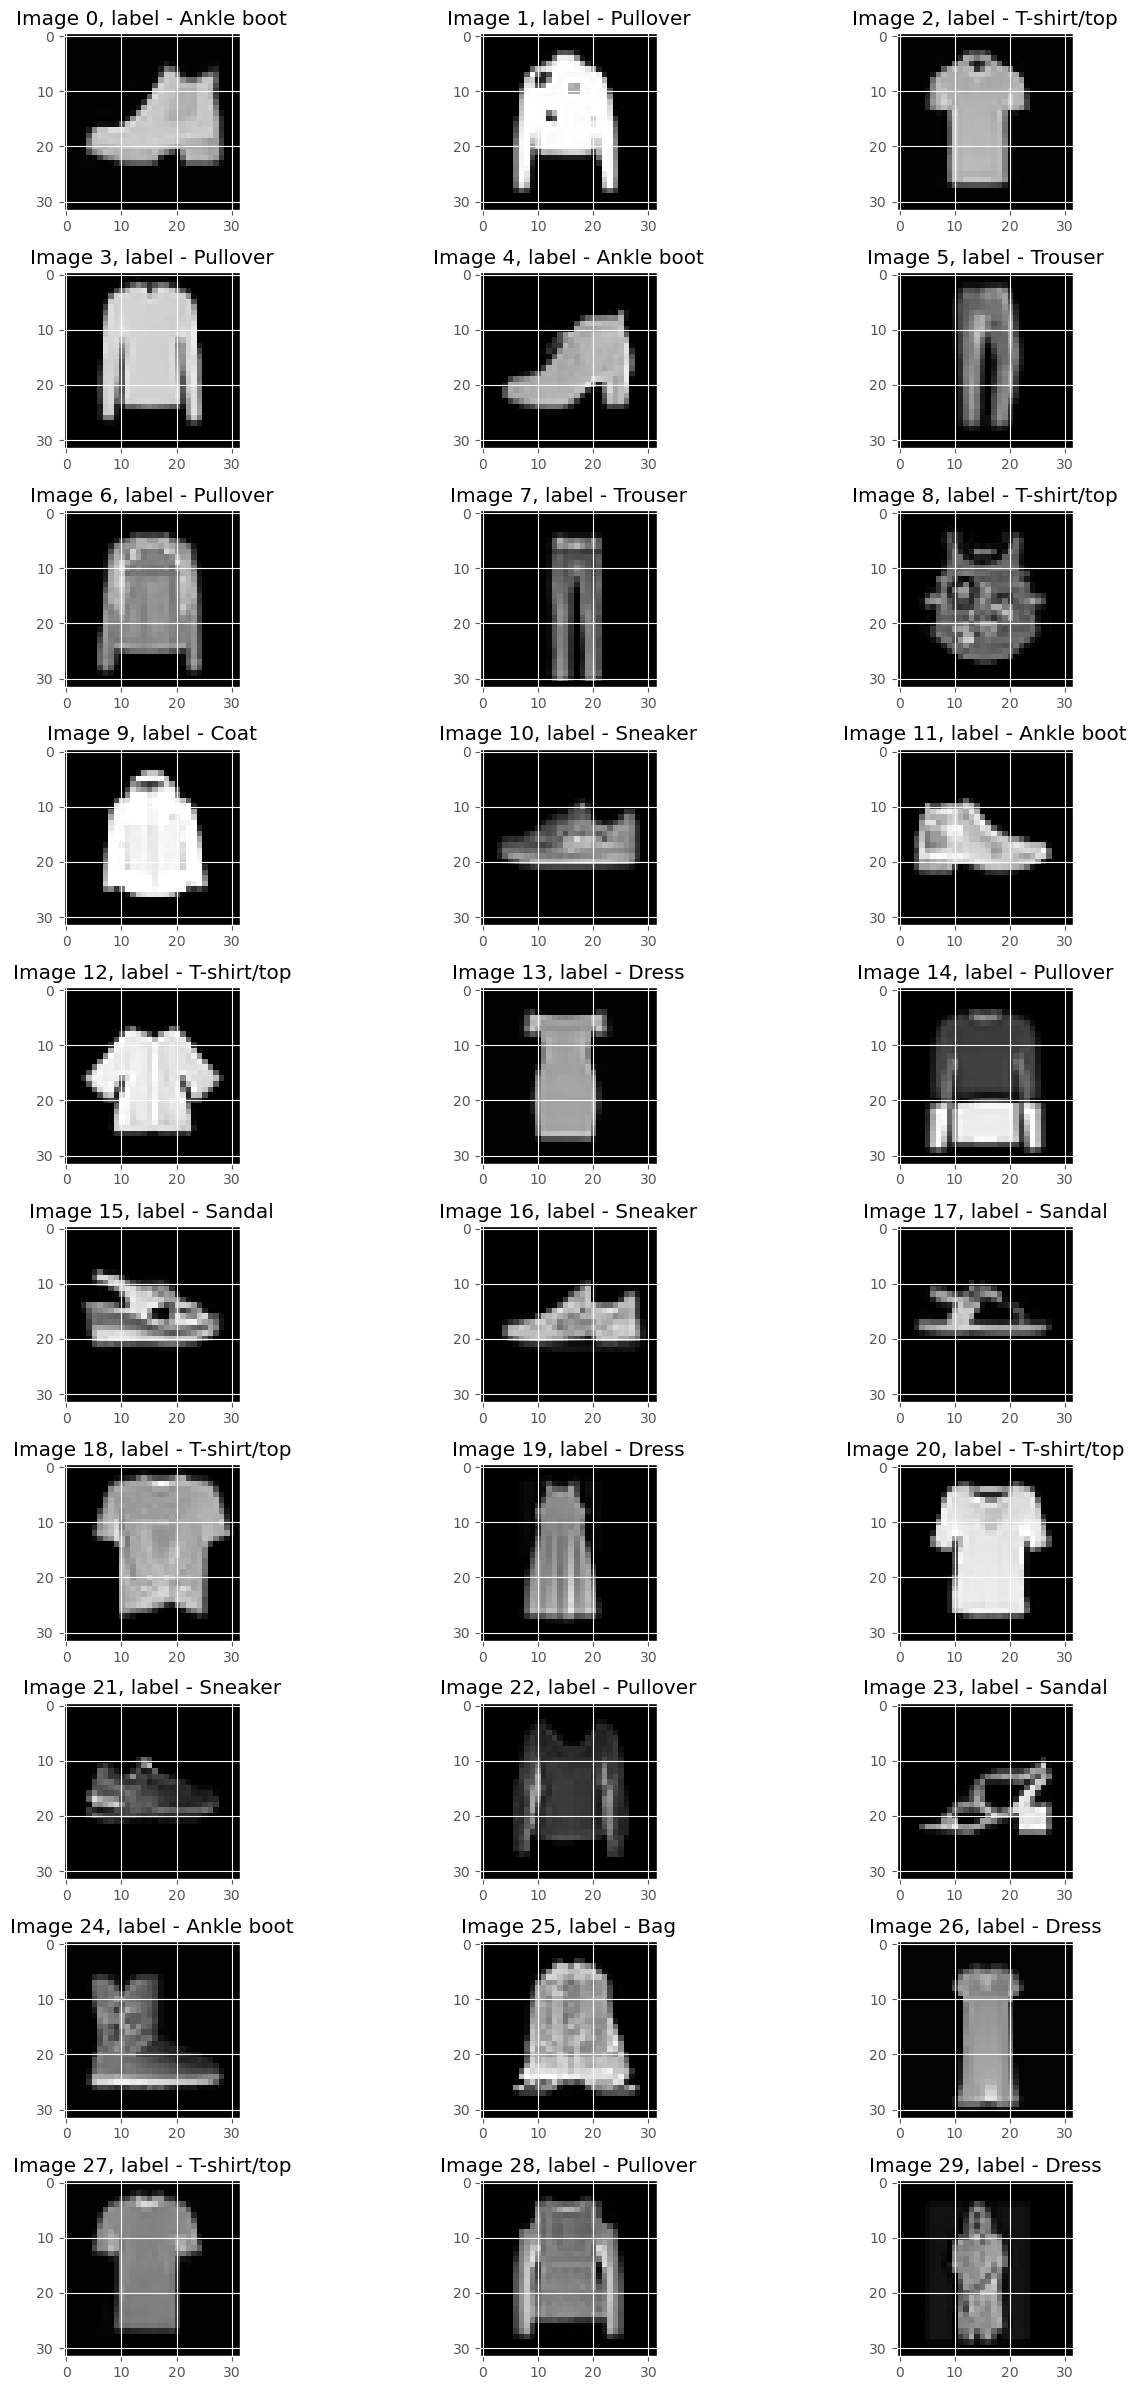

In [132]:
# Number of images to display
num_images = 30

# Calculate the number of rows and columns for subplots
num_rows = (num_images + 2) // 3  # Ensure at least 3 images per row
num_cols = min(num_images, 3)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 24))

# Let's plot several images on a separate subplot
for img_index in range(num_images):
    img = Xtrain.iloc[img_index].values.reshape((32,32))
    row_index = img_index // num_cols
    col_index = img_index % num_cols
    axes[row_index,col_index].imshow(img, cmap='gray',vmin=0,vmax=255)
    axes[row_index,col_index].set_title(f'Image {img_index}, label - {label_names[ytrain.iloc[img_index]]}')  # Add title to each subplot

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

Now let's see how much data we have for each type of label:

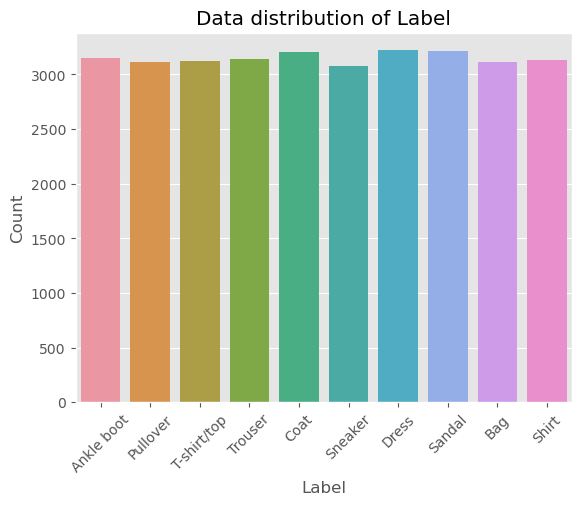

In [133]:
sns.countplot(x=ytrain.map(label_names))
plt.xlabel('Label')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('Data distribution of Label')
plt.show()

It seems that we have almost equal amount of labels - class imbalance is almost zero. Therefore, accuracy is a valid metric to use.

Now let's try to plot histograms for every pixel and see what values they take across all pictures in train set:

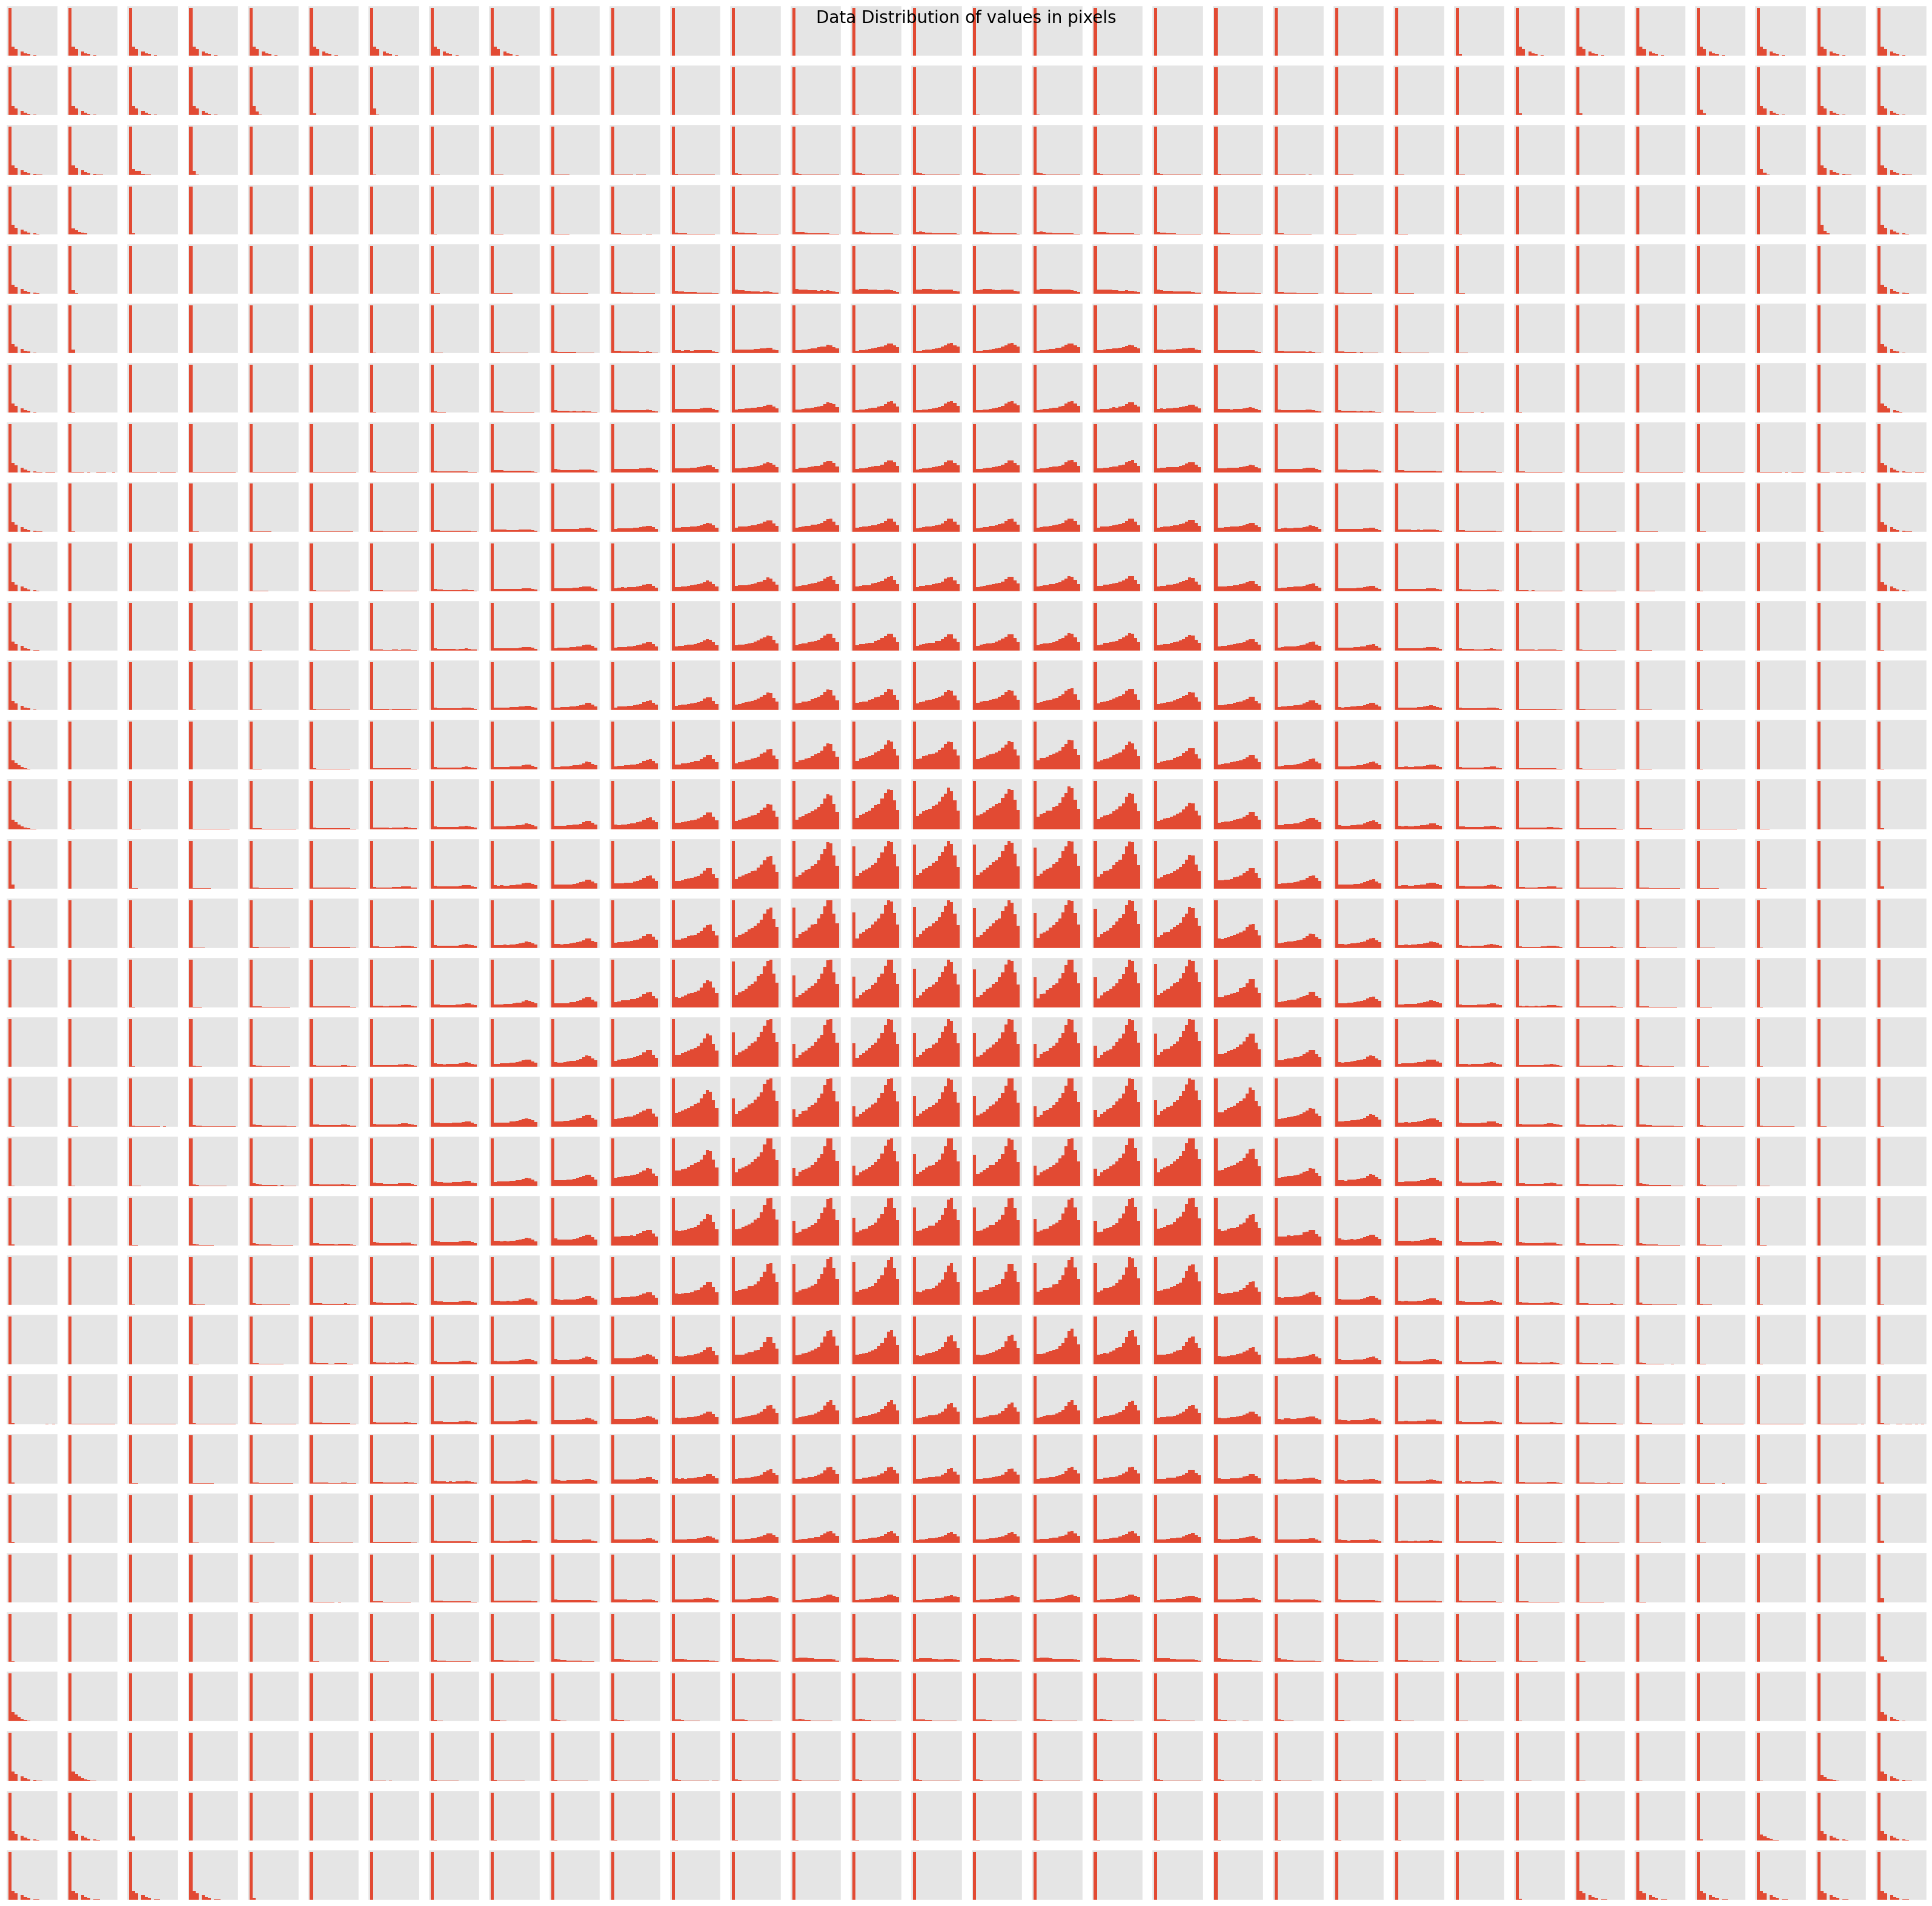

In [134]:
axes = Xtrain.hist(bins=15, figsize=(32,32))
for ax in axes.flatten():
      ax.set_xticks([])
      ax.set_yticks([])
      ax.tick_params(axis='both', which='both', length=0)
      ax.set_title("")

plt.suptitle("Data Distribution of values in pixels",fontsize=20)
plt.tight_layout()
plt.show()

It seems that pixels a the center have a wider range of values, which mean they contain basic information about the image.

Now let's see if our data points are linearly separable: 

In [135]:
# Apply PCA for dimensionality reduction to 3 components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(Xtrain)

# Create trace for each class
traces = []
for label in range(10):
    indices = (ytrain == label)
    trace = go.Scatter3d(
        x=X_pca[indices, 0],
        y=X_pca[indices, 1],
        z=X_pca[indices, 2],
        mode='markers',
        marker=dict(
            size=5,
            opacity=0.9,
            color=label,  # Use label as color for differentiation
            colorscale='Viridis'
        ),
        name=label_names[label],
        visible='legendonly'  # Set visibility to toggle with legend item
    )
    traces.append(trace)

# Create buttons for toggling visibility
buttons = []
for i, label in enumerate(label_names.values()):
    button = dict(
        label=label,
        method='update',
        args=[{'visible': [trace.visible for trace in traces[:i+1]] + [False] * (len(traces) - (i + 1))}]
    )
    buttons.append(button)

# Create layout with buttons
layout = go.Layout(
    title='3D Visualization of Fashion-MNIST with PCA',
    scene=dict(
        xaxis=dict(title='Principal Component 1'),
        yaxis=dict(title='Principal Component 2'),
        zaxis=dict(title='Principal Component 3')
    ),
    updatemenus=[
        dict(
            buttons=buttons,
            direction='down',
            pad={'r': 10, 't': 10},
            showactive=True,
            x=0.1,
            xanchor='left',
            y=1.1,
            yanchor='top'
        )
    ],
    width=1000,
    height=800
)

# Create figure and plot
fig = go.Figure(data=traces, layout=layout)
fig.show()

Clearly, each pair of labels are not linearly separable. Nevertheless, there are some pairs which are close to be considered as such (for instance, Trouser - Pullower, or Coat -Sneaker)

## Models

### Feedforward Neural Network (FNN)

A feedforward neural network (FNN), also known as a multi-layer perceptron (MLP), is a type of artificial neural network where connections between units (neurons) do not form cycles. It consists of an input layer, one or more hidden layers, and an output layer. Each layer is composed of multiple neurons, and connections between neurons are directed from the input layer to the output layer. In each layer, output of one neuron is directed as an input in all neurons of next layer.

1. **Input Layer**: Receives input features (e.g., pixel values of images).
2. **Hidden Layers**: Process the input through a series of transformations using weighted connections and activation functions (e.g., ReLU, SELU). Usually, only one activation function used for all hidden layers.
3. **Output Layer**: Produces the final output (e.g., class probabilities for different fashion items). It uses different activation function, based on a type of task:
      
      - Binary classification - **sigmoid**:
      $$ g(z) = \sigma(z) = \frac{1}{1 + e^{-z}} = \frac{e^z}{1 + e^z} $$
      where $ z = w^\top h + w_0 $ is the output of the output layer
      
      ---
      - Multilabel classification (classification into $c$ Classes) - **normalized softmax**:
      $$ \text{softmax}(z) = \frac{e^{z_i}}{e^{z_1} + e^{z_2} + \dots + e^{z_c}} $$
      where $ z = (z_1, z_2, \dots, z_c) $ is the vector of outputs from the $ c $ neurons in the output layer.
      
      ---
      - Regression - **identity**. That means, target prediction is:
      $$ \hat{Y} = w^\top h + w_0 $$
      where $ w \in \mathbb{R}^{n-1} $ and $ w_0 $ are the weights of the output neuron.


#### Pros of Feedforward Neural Network
- **Universal Function Approximator**: FNNs have the capability to approximate any continuous function, given a sufficiently large number of neurons and layers.
- **Scalability**: FNNs can be scaled by adding more layers and neurons to handle complex tasks and datasets.
- **Straightforward Implementation**: Relatively easier to understand and implement compared to more complex architectures like convolutional neural networks (CNNs) or recurrent neural networks (RNNs).

#### Cons of Feedforward Neural Network
- **Limited to Fixed-size Inputs**: FNNs require fixed-size input vectors, making them less suitable for tasks involving variable-length sequences (e.g., text, time series).
- **Lack of Spatial Awareness**: FNNs do not explicitly model spatial relationships in data (e.g., image pixels), which is essential for tasks like image classification.
- **Prone to Overfitting**: Without regularization techniques, FNNs can overfit to training data, especially with large model capacities.

#### Suitability for MNIST Fashion Classification Task
- **Prospective Suitability**: FNNs can perform well on structured data tasks like image classification when combined with appropriate preprocessing (e.g., flattening images into vectors).
- **Limitations**: FNNs may struggle with capturing spatial dependencies in images (e.g., distinguishing patterns in clothing items) compared to specialized architectures like CNNs designed for computer vision tasks.
- **Experimentation Required**: Despite limitations, FNNs can serve as a baseline model for MNIST Fashion classification. Experimentation with different hidden layer architectures, activation functions, and regularization techniques will be conducted to optimize performance.

For all models, we will use **minibatch training** with fixed **batchsize of 128** datapoints

First, let's see performance without **any regularization**:

##### No regularization

We are tasked with classification of Clothes to several labels. Throught training we will try to minimize **loss function**.
In this task we will use **categorical cross-entropy loss**:
$$ L(Y, \hat{p}) = -\sum_{j=1}^c \mathbf{1}_{Y=j} \log \hat{p}_j = -\log \hat{p}_Y $$

where $ \mathbf{1}_{Y=j} = 1 $ when $ Y = j $ and $ \mathbf{1}_{Y=j} = 0 $ otherwise.

---
Here, we are going to experiment with activation functions on hidden layers and different optimalization methods.
1. **Activation functions**:
  - *Leaky Rectified Linear Unit* (Leaky ReLU)
  The Leaky ReLU activation function \( g(z) \) is defined as:
  $$ g(z) = \begin{cases} 
  z & \text{for } z \geq 0, \\
  0.01z & \text{for } z < 0.
  \end{cases} $$
  Unlike ReLU, Leaky ReLU has a non-zero gradient for negative values of \( z \), which aids in training (Maas, 2013)
  - *Scaled Exponential Linear Unit* (SELU)
  The SELU activation function \( g(z) \) is defined as:
  $$ g(z) = \begin{cases} 
  \lambda z & \text{for } z \geq 0, \\
  \alpha(e^z - 1) & \text{for } z < 0,
  \end{cases} $$
  This modification of ReLU also ensures a non-zero gradient everywhere, which aids in training.

---
2. **Optimalization methods**: 
  - *Stochastic Gradient Descent* (SGD) with Momentum

  SGD with Momentum is an extension of the standard Stochastic Gradient Descent optimization algorithm. It addresses the issue of slow convergence and oscillations in the update steps of SGD.  The key idea is to add momentum to the gradient update, which helps accelerate the gradient vectors in the right directions, leading to faster convergence and reduced oscillations.

  - *Root Mean Square Propagation* (RMSProp)

  RMSProp is another optimization algorithm designed to address the limitations of SGD, particularly in adapting the learning rate for each parameter during training. It normalizes the gradient by a running average of its recent magnitudes, which helps in scaling down the learning rates for frequently occurring features.

  - *Adam* (Adaptive Moment Estimation)

Adam combines the benefits of both Momentum and RMSProp algorithms. It computes adaptive learning rates for each parameter by estimating both the first-order moment (mean) and the second-order moment (uncentered variance) of the gradients.

#####
For hyperparameter tuning I will use `optuna` library. You can see more here: https://optuna.org/

First, we prepare data:

In [67]:
# Convert NumPy arrays to PyTorch tensors
Xtrain_tensor = torch.tensor(Xtrain.values, dtype=torch.float32)
Xval_tensor = torch.tensor(Xval.values, dtype=torch.float32)
Xtest_tensor = torch.tensor(Xtest.values, dtype=torch.float32)
ytrain_tensor = torch.tensor(ytrain.values, dtype=torch.long) 
yval_tensor = torch.tensor(yval.values, dtype=torch.long)
ytest_tensor = torch.tensor(ytest.values, dtype=torch.long)

# Create PyTorch datasets
train_dataset = TensorDataset(Xtrain_tensor, ytrain_tensor)
val_dataset = TensorDataset(Xval_tensor, yval_tensor)
test_dataset = TensorDataset(Xtest_tensor, ytest_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCHSIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCHSIZE)

Now we define structure of the network: 

In [68]:
def define_model(trial, activation):
    # Optimize the number of layers and hidden units in each layer
    # Use different activation function for all hidden layers
    
    n_layers = trial.suggest_int("n_layers", 3, 9)
    layers = []

    in_features = 32 * 32
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 256)
        layers.append(nn.Linear(in_features, out_features))
        
        # Add activation function based on the provided parameter
        if activation == "LeakyReLU":
            layers.append(nn.LeakyReLU())
        elif activation == "SELU":
            layers.append(nn.SELU())

        # We will use dropout later
        # p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.5)
        # layers.append(nn.Dropout(p))

        in_features = out_features
        
    layers.append(nn.Linear(in_features, CLASSES))
    # We use CrossEntropyLoss() as a loss function, so no activation function needed here 

    return nn.Sequential(*layers)

Here is the hyperparameters that will be tuned:
- `n_layers` - number of layers
- `n_units_li` - number of neurons in layer $i$
- `activation` - **LeakyReLU** or **SELU**, based on the argument provided
- `lr` - learning rate of the model
- `optimizer` - **Adam**, **RMSprop** or **SDG** with momentum
- `momentum` - momentum (velocity) for **SDG**

Now we need to define `objective` function. In Optuna, you need to define the objective function as a Python function that takes a trial object as input and returns a scalar value representing the performance of the model with the given hyperparameters (here - validation accuracy):

In [69]:
def objective_optimizer(trial,optimizer_name):
    # Generate the activation function choice for the entire model
    activation = trial.suggest_categorical("activation", ["LeakyReLU", "SELU"])

    # Generate the model with the chosen activation function
    model = define_model(trial, activation).to(DEVICE)

    # Define loss function
    loss_fn = torch.nn.CrossEntropyLoss()

    # Generate the optimizer choice
    lr = trial.suggest_float("lr", 1e-6, 1e-2, log=True)

    # Create the optimizer based on the chosen type
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        momentum = trial.suggest_float("momentum", 0.6, 1.5)  # Add momentum as a hyperparameter
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    # Training and validation of the model
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_loader):
                data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
                # Forward pass: compute the output of the model
                output = model(data)

                # Compute the predicted labels (class indices with maximum probability)
                _, predicted = torch.max(output, 1)

                # Update total number of samples
                total += target.size(0)

                # Update number of correct predictions
                correct += (predicted == target).sum().item()

        accuracy = correct / total

        trial.report(accuracy, epoch)

        # Handle pruning based on intermediate value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

Now we can create several study object. Each study will focus on finding best hyperparameters for each optimizer:

In [70]:
# Define a function to retrieve optimizer-specific results
def get_optimizer_results(study, optimizer_name):
    best_score = None
    best_params = None

    # Retrieve completed trials for the specified optimizer
    completed_trials = [t for t in study.trials if t.state == TrialState.COMPLETE]

    if len(completed_trials) > 0:
        # Get the best trial based on the maximum evaluation score (accuracy)
        best_trial = study.best_trial

        # Extract the best score (evaluation metric value)
        best_score = best_trial.value

        # Extract the best parameters corresponding to the best trial
        best_params = best_trial.params

        # Additional handling for SGD optimizer (retrieve lr and momentum)
        if optimizer_name == "SGD":
            best_params["lr"] = best_trial.params["lr"]
            best_params["momentum"] = best_trial.params["momentum"]
        else:
            best_params["lr"] = best_trial.params["lr"]

    return best_score, best_params

In [71]:
# Initialize empty dictionaries to store results
max_scores = {}
best_params_dict = {}
studies = []
# Loop through each optimizer name and retrieve results
for optimizer_name in ["Adam", "RMSprop", "SGD"]:
    # Create a new Optuna study for the current optimizer
    study = optuna.create_study(direction="maximize",sampler=sampler)
    studies.append(study)
    
    # Optimize the objective function with the specified optimizer
    study.optimize(lambda trial: objective_optimizer(trial, optimizer_name=optimizer_name), n_trials=100, timeout=None)
    
    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
    
    # Retrieve the maximum evaluation score and best parameters for the current optimizer
    max_score, best_params = get_optimizer_results(study, optimizer_name)

    # Store results in dictionaries
    max_scores[optimizer_name] = max_score
    best_params_dict[optimizer_name] = best_params
    
    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))
    
    print("Best trial:")
    trial = study.best_trial
    
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2024-05-12 13:20:00,567] A new study created in memory with name: no-name-15d6a8c3-bf58-4540-b807-5bf14c4b6494


[I 2024-05-12 13:22:34,282] Trial 0 finished with value: 0.8371428571428572 and parameters: {'activation': 'SELU', 'n_layers': 8, 'n_units_l0': 182, 'n_units_l1': 86, 'n_units_l2': 53, 'n_units_l3': 41, 'n_units_l4': 189, 'n_units_l5': 133, 'n_units_l6': 4, 'n_units_l7': 21, 'lr': 5.310745611565025e-05}. Best is trial 0 with value: 0.8371428571428572.
[I 2024-05-12 13:27:14,841] Trial 1 finished with value: 0.7891428571428571 and parameters: {'activation': 'SELU', 'n_layers': 7, 'n_units_l0': 65, 'n_units_l1': 216, 'n_units_l2': 206, 'n_units_l3': 256, 'n_units_l4': 243, 'n_units_l5': 127, 'n_units_l6': 102, 'lr': 0.0026739743128979124}. Best is trial 0 with value: 0.8371428571428572.
[I 2024-05-12 13:28:23,085] Trial 2 finished with value: 0.8215238095238095 and parameters: {'activation': 'LeakyReLU', 'n_layers': 4, 'n_units_l0': 87, 'n_units_l1': 6, 'n_units_l2': 97, 'n_units_l3': 69, 'lr': 8.690606691491145e-05}. Best is trial 0 with value: 0.8371428571428572.
[I 2024-05-12 13:29:41

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  78
  Number of complete trials:  22
Best trial:
  Value:  0.8517142857142858
  Params: 
    activation: SELU
    n_layers: 5
    n_units_l0: 131
    n_units_l1: 176
    n_units_l2: 155
    n_units_l3: 192
    n_units_l4: 81
    lr: 0.00039865567323405405


[I 2024-05-12 14:32:32,351] Trial 0 finished with value: 0.7023809523809523 and parameters: {'activation': 'LeakyReLU', 'n_layers': 9, 'n_units_l0': 208, 'n_units_l1': 249, 'n_units_l2': 185, 'n_units_l3': 251, 'n_units_l4': 225, 'n_units_l5': 160, 'n_units_l6': 241, 'n_units_l7': 168, 'n_units_l8': 8, 'lr': 7.2573708669624346e-06}. Best is trial 0 with value: 0.7023809523809523.
[I 2024-05-12 14:34:45,124] Trial 1 finished with value: 0.8278095238095238 and parameters: {'activation': 'LeakyReLU', 'n_layers': 8, 'n_units_l0': 138, 'n_units_l1': 227, 'n_units_l2': 244, 'n_units_l3': 177, 'n_units_l4': 49, 'n_units_l5': 135, 'n_units_l6': 193, 'n_units_l7': 244, 'lr': 5.220896689125964e-05}. Best is trial 1 with value: 0.8278095238095238.
[I 2024-05-12 14:36:57,985] Trial 2 finished with value: 0.7397142857142858 and parameters: {'activation': 'SELU', 'n_layers': 6, 'n_units_l0': 85, 'n_units_l1': 239, 'n_units_l2': 254, 'n_units_l3': 76, 'n_units_l4': 68, 'n_units_l5': 247, 'lr': 9.5604

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  90
  Number of complete trials:  10
Best trial:
  Value:  0.8380952380952381
  Params: 
    activation: SELU
    n_layers: 7
    n_units_l0: 164
    n_units_l1: 216
    n_units_l2: 67
    n_units_l3: 250
    n_units_l4: 70
    n_units_l5: 124
    n_units_l6: 252
    lr: 8.969773904539372e-05


[I 2024-05-12 15:07:29,692] Trial 0 finished with value: 0.10323809523809524 and parameters: {'activation': 'SELU', 'n_layers': 6, 'n_units_l0': 60, 'n_units_l1': 173, 'n_units_l2': 232, 'n_units_l3': 177, 'n_units_l4': 55, 'n_units_l5': 102, 'lr': 3.0270460539834934e-06, 'momentum': 1.159037793942455}. Best is trial 0 with value: 0.10323809523809524.
[I 2024-05-12 15:09:13,019] Trial 1 finished with value: 0.10323809523809524 and parameters: {'activation': 'SELU', 'n_layers': 9, 'n_units_l0': 172, 'n_units_l1': 168, 'n_units_l2': 46, 'n_units_l3': 6, 'n_units_l4': 94, 'n_units_l5': 174, 'n_units_l6': 250, 'n_units_l7': 115, 'n_units_l8': 63, 'lr': 3.369003571029625e-05, 'momentum': 1.310374150690832}. Best is trial 0 with value: 0.10323809523809524.
[I 2024-05-12 15:10:42,469] Trial 2 finished with value: 0.10323809523809524 and parameters: {'activation': 'SELU', 'n_layers': 3, 'n_units_l0': 252, 'n_units_l1': 153, 'n_units_l2': 125, 'lr': 3.5819121800131067e-06, 'momentum': 1.0234697

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  40
  Number of complete trials:  60
Best trial:
  Value:  0.8498095238095238
  Params: 
    activation: SELU
    n_layers: 8
    n_units_l0: 238
    n_units_l1: 224
    n_units_l2: 138
    n_units_l3: 96
    n_units_l4: 44
    n_units_l5: 144
    n_units_l6: 133
    n_units_l7: 110
    lr: 0.004875918002645315
    momentum: 0.8390189117498954


We can see that some trials were prunned. Optuna automatically stop unpromising trials at the early stages of the training (a.k.a., automated early-stopping). `report()` periodically monitors the intermediate objective values. `should_prune()` decides termination of the trial that does not meet a predefined condition.

Let's save results in DataFrames:

In [72]:
# Create pandas DataFrames from the results dictionaries
max_scores_df = pd.DataFrame(data=max_scores, index=["ForwardNN"])
best_params_df = pd.DataFrame(data=best_params_dict)
best_params_df

Adam  RMSprop       SGD
activation      SELU     SELU      SELU
n_layers           5        7         8
n_units_l0       131      164       238
n_units_l1       176      216       224
n_units_l2       155       67       138
n_units_l3       192      250        96
n_units_l4        81       70        44
lr          0.000399  0.00009  0.004876
n_units_l5       NaN      124       144
n_units_l6       NaN      252       133
n_units_l7       NaN      NaN       110
momentum         NaN      NaN  0.839019

**SELU** seems to be the best option for all 3 optimizers. We will use it from now on

In [73]:
# Highlight maximum value in max_scores_df using styling
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: rgba(255, 165, 0, 0.5)' if v else '' for v in is_max]

# Apply the custom style function to the DataFrame
styled_max_scores_df = max_scores_df.style.apply(highlight_max)
styled_max_scores_df

We can see that best optimizer is Adam, with 0.8517 accuracy on validation data. It also requires less complicated model to give better accuracy.

Optuna has possibility to visualize hyperparameter importances based on elapsed studies, the optimization history and the learning curves of the trials. Let's see it:

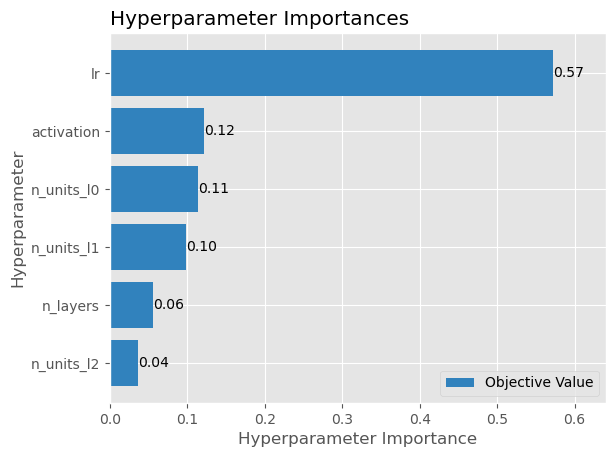

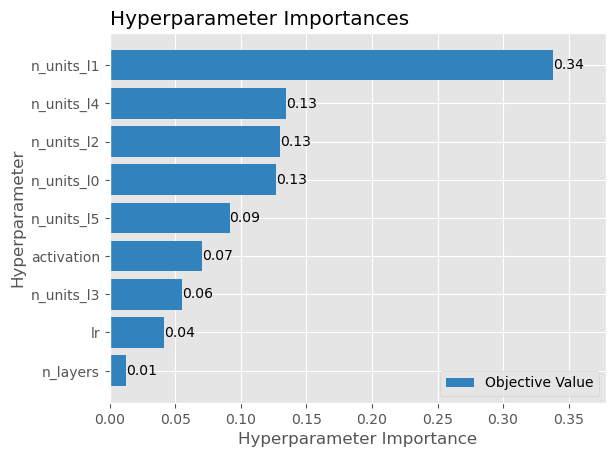

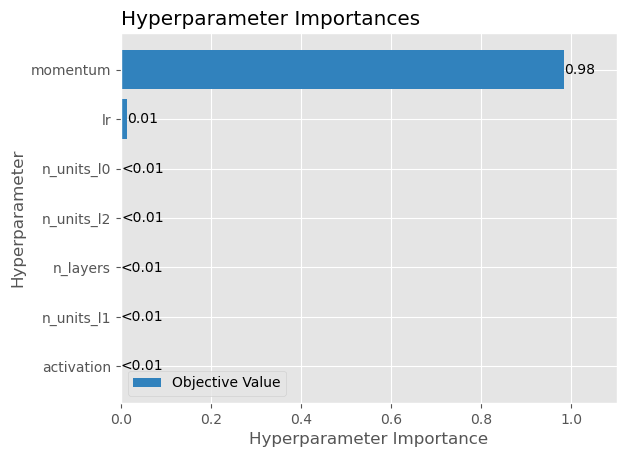

In [81]:
from optuna.visualization.matplotlib import plot_param_importances, plot_optimization_history, plot_terminator_improvement
import warnings
from optuna.exceptions import ExperimentalWarning
warnings.filterwarnings("ignore", category=ExperimentalWarning)

for i in range(len(studies)):
      plot_param_importances(studies[i])

We can see that important hyperparameters were different for every optimizer:
- Adam is very dependent on learning rate. Activation function and number of neurons in first 2 layers also had a great effect. 
- RMSProp requires fine tuning of number of neurons in almost all layers
- SDG is the most interesting here: 98% dependency on the momentum - even learning rate nor number of layers did had any effect 

We need to focus on tuning them better for next studies.

We can also plot optimization history of all trials in a study:

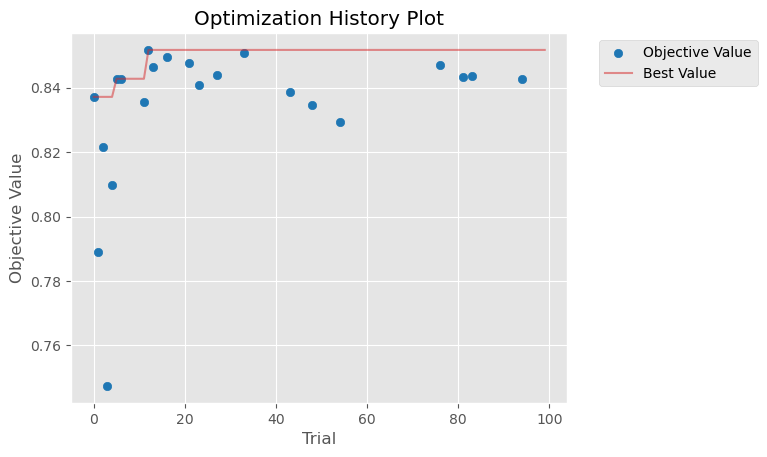

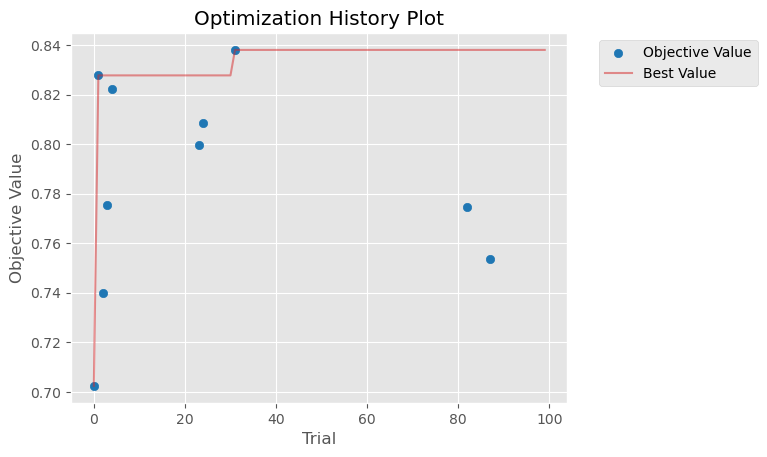

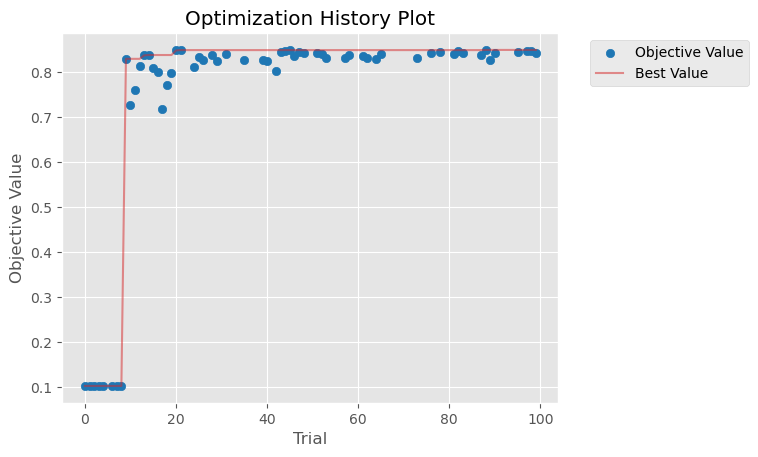

In [82]:
for i in range(len(studies)):
      plot_optimization_history(studies[i])

- Both Adam and RMSProp shows a good performance: on 20 - 30 iteration we already have best accuracy possible (for this ammount of trials)
- Things are different with SDG: for first 10 iterations it seems to oscilate a lot, seemengly lost on wast plane of loss function. I assume i got lucky, and optuna quickly suggested another momentum to experiment with.

We can also see plot of the potentials for future objective improvement.

The function visualizes the objective improvement potentials, evaluated with `improvement_evaluator`. It helps to determine whether we should continue the optimization or not.

100%|██████████| 100/100 [00:04<00:00, 20.31it/s]


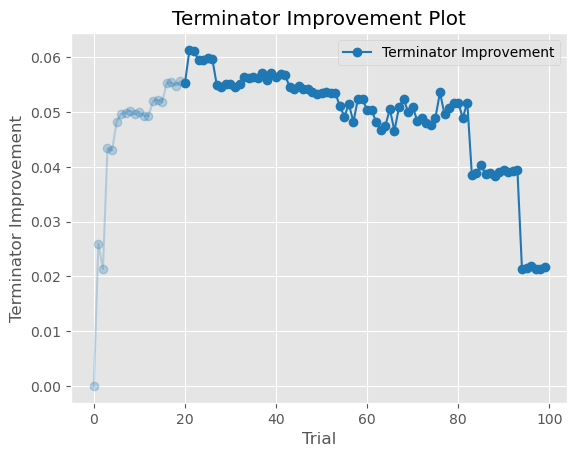

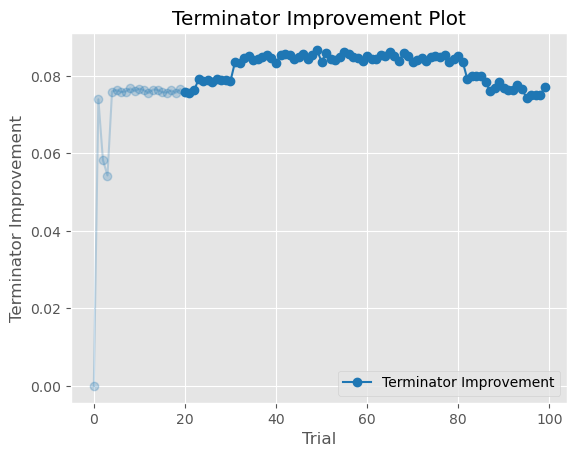

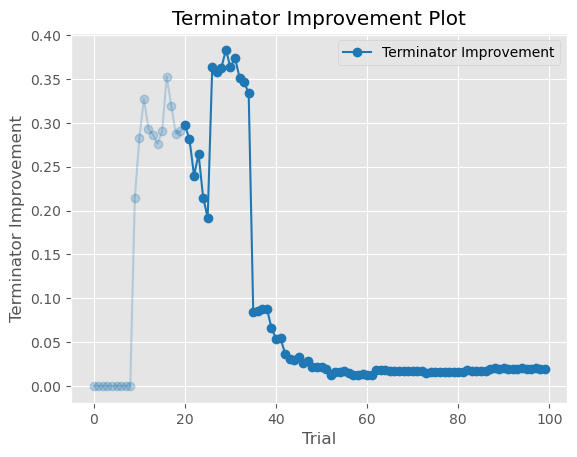

In [83]:
for i in range(len(studies)):
      plot_terminator_improvement(studies[i])

It seems that we could have continued study on RMSProp optimizer. Of course, we can't run indefenetily just to be sure in our choice. Given limited computational power and time, **we will use Adam optimizer** for this task

#### Dropout

Now we will add dropout technique.

**Dropout** is a regularization technique used to prevent overfitting and improve the generalization ability of the model. It involves randomly dropping (i.e., setting to zero) a proportion of neurons or units in a layer during training. This prevents the units from co-adapting too much to the training data and encourages the network to learn more robust and generalizable features.

After that, we will try out combination dropout + L2 regularization.

**L2 regularization** is weight vector norm penalization.

A regularization term $ \Omega(w) $ is added to the objective function $ J(w) $, and the new regularized objective function becomes
   $$ J_0(w) = J(w) + \lambda \Omega(w) $$
   where the hyperparameter $ \lambda $ controls the strength of regularization.

- For L2 regularization, the regularization term added to the $ i $-th layer with weight vector $ w^{(i)} $ is
   $$ \Omega(w) = k \| w^{(i)} \|_2^2 = \sum_j |w_j^{(i)}|^2 $$


Let's modify our `define_model` and `objective` functions. We will add Dropout to layers, and in optimizer parameters, we define `wight_decay`, $\lambda$ parameter used for L2 regularization:

In [104]:
def define_model(trial):
    # Optimize the number of layers, hidden units in each layer and dropout probability
    
    n_layers = trial.suggest_int("n_layers", 3, 16)
    layers = []

    in_features = 32 * 32
    for i in range(n_layers):
      out_features = trial.suggest_int("n_units_l{}".format(i), 4, 256)
      layers.append(nn.Linear(in_features, out_features))
      layers.append(nn.SELU())
      p = trial.suggest_float("dropout_l{}".format(i), 0.3, 0.6)
      layers.append(nn.Dropout(p))
      in_features = out_features
        
    layers.append(nn.Linear(in_features, CLASSES))
    # We use CrossEntropyLoss() as a loss function, so no activation function needed here 

    return nn.Sequential(*layers)

In [105]:
def objective_dropout(trial, reg_flag):
    # Generate the model with the chosen activation function
    model = define_model(trial).to(DEVICE)

    # Define loss function
    loss_fn = torch.nn.CrossEntropyLoss()

    # Generate the optimizer choice
    lr = trial.suggest_float("lr", 1e-6, 1e-2, log=True)

    # Create the optimizer based on the chosen type fo regularization
    if reg_flag:
        weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
    # Training and validation of the model
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_loader):
                data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
                # Forward pass: compute the output of the model
                output = model(data)

                # Compute the predicted labels (class indices with maximum probability)
                _, predicted = torch.max(output, 1)

                # Update total number of samples
                total += target.size(0)

                # Update number of correct predictions
                correct += (predicted == target).sum().item()

        accuracy = correct / total

        trial.report(accuracy, epoch)

        # Handle pruning based on intermediate value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [106]:
# Loop through retrieve results
max_scores = []
best_params = []
for reg_flag in [False,True]:
    # Create a new Optuna study for the current optimizer
    study = optuna.create_study(direction="maximize",sampler=sampler)
    studies.append(study)
    
    # Optimize the objective function with the specified optimizer
    study.optimize(lambda trial: objective_dropout(trial, reg_flag=reg_flag), n_trials=100, timeout=None)
    
    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
    
    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))
    
    print("Best trial:")
    trial = study.best_trial
    
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

     # Store results
    max_scores.append(trial.value)
    best_params.append(trial.params)

[I 2024-05-12 19:27:43,957] A new study created in memory with name: no-name-e0d77a21-d44a-4309-b53c-a91b70a26c4b
[I 2024-05-12 19:32:56,423] Trial 0 finished with value: 0.09371428571428571 and parameters: {'n_layers': 15, 'n_units_l0': 126, 'dropout_l0': 0.33459630142382757, 'n_units_l1': 126, 'dropout_l1': 0.47512091809573576, 'n_units_l2': 234, 'dropout_l2': 0.46000471665583087, 'n_units_l3': 255, 'dropout_l3': 0.4239172237802772, 'n_units_l4': 40, 'dropout_l4': 0.45246445211127695, 'n_units_l5': 198, 'dropout_l5': 0.5823742196530642, 'n_units_l6': 44, 'dropout_l6': 0.5672337384365083, 'n_units_l7': 232, 'dropout_l7': 0.4180860409687507, 'n_units_l8': 222, 'dropout_l8': 0.44436458900391873, 'n_units_l9': 199, 'dropout_l9': 0.544671020078455, 'n_units_l10': 131, 'dropout_l10': 0.5969286158774408, 'n_units_l11': 15, 'dropout_l11': 0.5683659171735417, 'n_units_l12': 102, 'dropout_l12': 0.37602804149468444, 'n_units_l13': 244, 'dropout_l13': 0.511515935320767, 'n_units_l14': 71, 'dropo

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  61
  Number of complete trials:  39
Best trial:
  Value:  0.8306666666666667
  Params: 
    n_layers: 4
    n_units_l0: 196
    dropout_l0: 0.3184503663046622
    n_units_l1: 72
    dropout_l1: 0.48707274961452474
    n_units_l2: 144
    dropout_l2: 0.34243343979766155
    n_units_l3: 55
    dropout_l3: 0.34648999507186545
    lr: 0.0001499098091686957


[I 2024-05-12 21:21:46,677] Trial 0 finished with value: 0.3858095238095238 and parameters: {'n_layers': 14, 'n_units_l0': 102, 'dropout_l0': 0.5444913198067758, 'n_units_l1': 80, 'dropout_l1': 0.3876115533492429, 'n_units_l2': 222, 'dropout_l2': 0.3978171190409879, 'n_units_l3': 57, 'dropout_l3': 0.41435135221261254, 'n_units_l4': 120, 'dropout_l4': 0.5550148567687225, 'n_units_l5': 46, 'dropout_l5': 0.3746037981162154, 'n_units_l6': 69, 'dropout_l6': 0.48583062342127303, 'n_units_l7': 46, 'dropout_l7': 0.44198068367630705, 'n_units_l8': 169, 'dropout_l8': 0.30063940626346214, 'n_units_l9': 50, 'dropout_l9': 0.4144138004976024, 'n_units_l10': 40, 'dropout_l10': 0.5862834299962794, 'n_units_l11': 151, 'dropout_l11': 0.37810124081113927, 'n_units_l12': 57, 'dropout_l12': 0.3805898106668764, 'n_units_l13': 187, 'dropout_l13': 0.40322569692265997, 'lr': 0.00030195990772705447, 'weight_decay': 0.00011326097958802583}. Best is trial 0 with value: 0.3858095238095238.
[I 2024-05-12 21:24:46,0

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  65
  Number of complete trials:  35
Best trial:
  Value:  0.8301904761904761
  Params: 
    n_layers: 4
    n_units_l0: 250
    dropout_l0: 0.4574649877563164
    n_units_l1: 140
    dropout_l1: 0.3909930395559792
    n_units_l2: 142
    dropout_l2: 0.42090557688571895
    n_units_l3: 182
    dropout_l3: 0.3127850227175035
    lr: 7.520988465597663e-05
    weight_decay: 5.825162492733541e-05


Best hyperparams (First one is with dropout only, second is dropout + L2 regularization):

In [107]:
best_params

[{'n_layers': 4,
  'n_units_l0': 196,
  'dropout_l0': 0.3184503663046622,
  'n_units_l1': 72,
  'dropout_l1': 0.48707274961452474,
  'n_units_l2': 144,
  'dropout_l2': 0.34243343979766155,
  'n_units_l3': 55,
  'dropout_l3': 0.34648999507186545,
  'lr': 0.0001499098091686957},
 {'n_layers': 4,
  'n_units_l0': 250,
  'dropout_l0': 0.4574649877563164,
  'n_units_l1': 140,
  'dropout_l1': 0.3909930395559792,
  'n_units_l2': 142,
  'dropout_l2': 0.42090557688571895,
  'n_units_l3': 182,
  'dropout_l3': 0.3127850227175035,
  'lr': 7.520988465597663e-05,
  'weight_decay': 5.825162492733541e-05}]

Let's see best values:

In [108]:
max_scores

[0.8306666666666667, 0.8301904761904761]

And some visualization:

<AxesSubplot:title={'left':'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

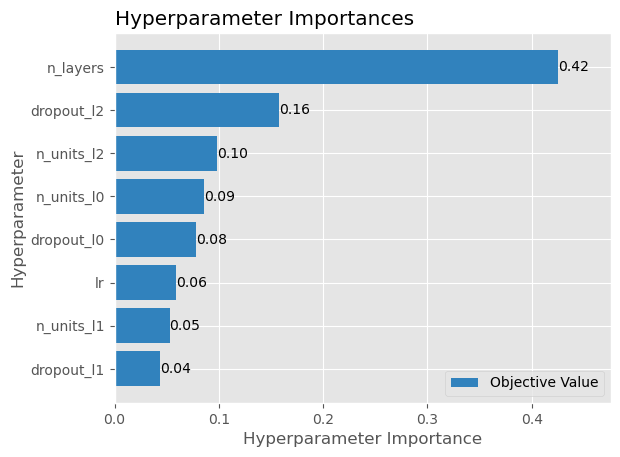

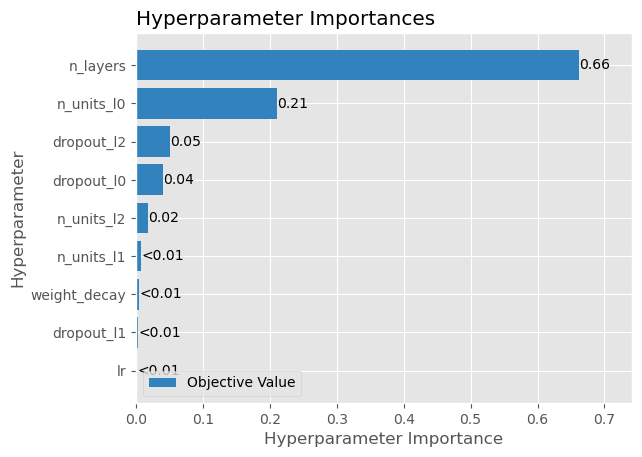

In [114]:
plot_param_importances(studies[-2])
plot_param_importances(studies[-1])

<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

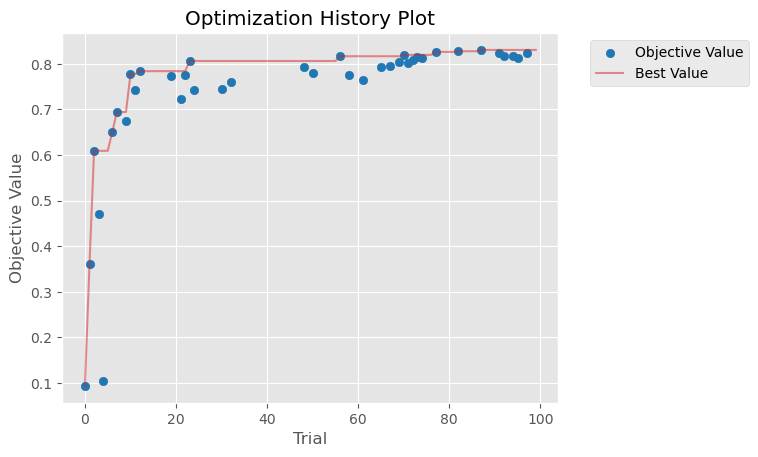

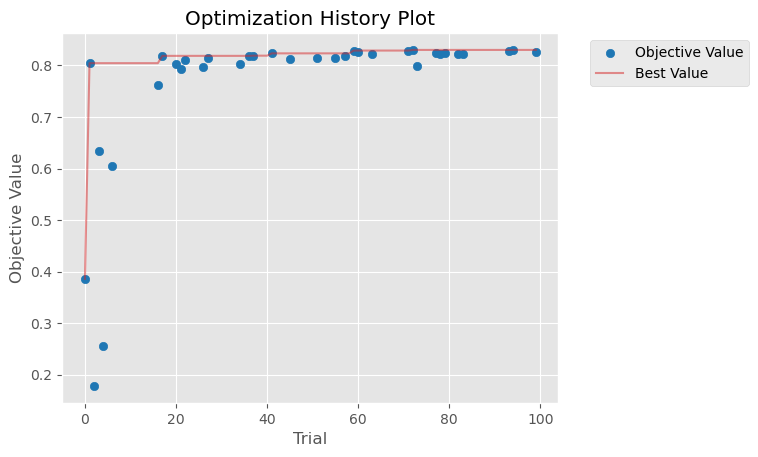

In [115]:
plot_optimization_history(studies[-2])
plot_optimization_history(studies[-1])

100%|██████████| 100/100 [00:03<00:00, 29.87it/s]


<AxesSubplot:title={'center':'Terminator Improvement Plot'}, xlabel='Trial', ylabel='Terminator Improvement'>

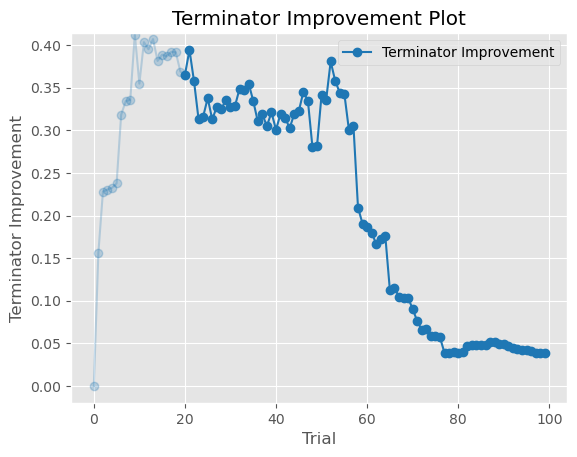

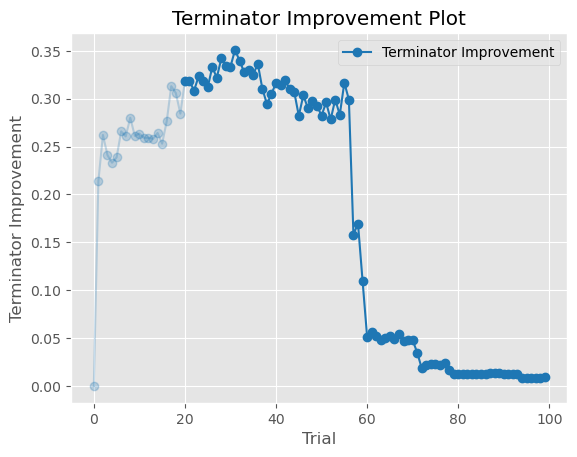

In [116]:
plot_terminator_improvement(studies[-2])
plot_terminator_improvement(studies[-1])

It appears then accuracy is lower then previous best result. I suppose it is related to the number of dropout layers we placed. If we reduce this number to 1 (maybe 2), we can get better results.

### Convolutional Neural Network (CNN)

Convolutional Neural Networks (CNNs) are a class of deep neural networks that are particularly effective for processing grid-like data, such as images. They are designed to automatically and adaptively learn spatial hierarchies of features by applying convolutional operations over input data.

#### Key Components:
- **Convolutional Layers**:
  - CNNs use convolutional layers to apply learnable filters (kernels) over input images, capturing spatial patterns and features.
- **Pooling Layers**:
  - Pooling layers (e.g., max pooling) downsample feature maps, reducing dimensionality while preserving important information.
- **Activation Functions**:
  - Non-linear activation functions (e.g., ReLU) introduce non-linearity into the network, enabling it to learn complex relationships.
- **Fully Connected Layers**:
  - Typically, CNNs conclude with one or more fully connected layers to make final predictions based on extracted features.

#### Pros of CNNs:
- **Hierarchical Feature Learning**:
  - CNNs automatically learn hierarchical representations of features, starting from simple features (edges, textures) to complex patterns (objects, shapes).
- **Translation Invariance**:
  - Convolutional operations create feature maps that are invariant to translations in the input, making CNNs robust to object position variations.
- **Parameter Sharing**:
  - CNNs use parameter sharing among convolutional filters, reducing the number of parameters and enhancing generalization.
- **Effective for Image Data**:
  - CNNs are specifically designed for processing grid-like data, making them highly effective for tasks like image classification.

#### Cons of CNNs:
- **Complexity**:
  - CNNs can be complex to design and train, especially with deeper architectures.
- **Computational Cost**:
  - Training CNNs can be computationally intensive, especially with large datasets and complex architectures.
- **Overfitting**:
  - Deep CNNs are prone to overfitting, especially when training data is limited or when the model capacity is too high.

#### Suitability for MNIST Fashion Classification:
- **Image Processing Task**:
  - CNNs are well-suited for image classification tasks like MNIST Fashion, where the input data consists of grayscale images of clothing items.
- **Spatial Hierarchies of Features**:
  - CNNs excel at capturing spatial hierarchies of features (e.g., shapes, textures, patterns) that are crucial for distinguishing different fashion items.
- **Robustness to Image Variations**:
  - CNNs are inherently robust to variations in image appearance, making them suitable for recognizing clothing items in different styles and orientations.

First, let's prepare our data more thorougly. I will predefine class for this:

In [239]:
from torch.utils.data import Dataset

class FashionDataset(Dataset):
    """Custom dataset class for fashion MNIST data."""

    def __init__(self, data, transform=None):
        """Initialize the dataset with input data and optional transformations."""
        self.fashion_MNIST = data.values
        self.transform = transform
        
        label = []
        image = []
        
        for i in self.fashion_MNIST:
            # last column is of labels.
            label.append(i[-1])
            image.append(i[0:-1])
        self.labels = np.asarray(label)
     
        # Dimension of Images = 28 * 28 * 1. where height = width = 28 and color_channels = 1.
        self.images = np.asarray(image).reshape(-1, 32, 32, 1).astype('float32')

    def __getitem__(self, index):
        """Retrieve an item (image and label) from the dataset at the specified index."""
        label = self.labels[index]
        image = self.images[index]

        # Apply transformations if specified
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        """Return the total number of samples in the dataset."""
        return len(self.labels)

In [240]:
from torchvision import transforms

train_data = pd.concat([Xtrain.copy(deep=True), ytrain.copy(deep=True)], axis=1)

val_data = pd.concat([Xval.copy(deep=True), yval.copy(deep=True)], axis=1)

test_data = pd.concat([Xtest.copy(deep=True), ytest.copy(deep=True)], axis=1)

train_dataset = FashionDataset(train_data, transform=transforms.ToTensor())
val_dataset = FashionDataset(val_data, transform=transforms.ToTensor())
test_dataset = FashionDataset(test_data, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCHSIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCHSIZE, shuffle=False)

In [241]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape)
print(labels.shape)

torch.Size([128, 1, 32, 32])
torch.Size([128])


As we can see from studies on FNN, placing dropout after each layer is a bad idea. Let's try to construct new architecture for CNN:

In [277]:
EPOCHS = 5

In [281]:
def define_model(trial):
    # Optimize the number of layers and hidden units in each layer
    # Parameters were calculate using http://layer-calc.com/
    # For input to be 64x8x8
    layers = []
    # 1x32x32 => 32x32x32
    layers.append(nn.Conv2d(in_channels=1,
                            out_channels=32,
                            kernel_size=3,
                            stride=1,
                            padding=1))
    layers.append(nn.SELU())
    # 32x32x32 => 32x16x16
    layers.append(nn.MaxPool2d(kernel_size=2,
                               stride=2,
                               padding=0))
    # 32x16x16 => 64x16x16
    layers.append(nn.Conv2d(in_channels=32,
                            out_channels=64,
                            kernel_size=3,
                            stride=1,
                            padding=1))
    layers.append(nn.SELU())
    # 64x16x16 => 64x8x8
    layers.append(nn.MaxPool2d(kernel_size=2,
                               stride=2,
                               padding=0))

    p = trial.suggest_float("dropout", 0.2, 0.4)
    layers.append(nn.Dropout2d(p))

    # 64x8x8 => 4096
    layers.append(nn.Flatten())
    
    layers.append(nn.Linear(in_features=64*8*8, out_features=512))
    layers.append(nn.Linear(in_features=512, out_features=CLASSES))
    # We use CrossEntropyLoss() as a loss function, so no activation function needed here 

    return nn.Sequential(*layers)

In [282]:
def objective(trial, train_loss,val_loss):
    # Generate the model with the chosen activation function
    model = define_model(trial).to(DEVICE)

    # Define loss function
    loss_fn = torch.nn.CrossEntropyLoss()

    # Generate the optimizer choice
    lr = trial.suggest_float("lr", 1e-6, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    avg_loss = 0.
    avg_vloss = 0.
    # Training and validation of the model
    for epoch in range(EPOCHS):
        print("EPOCH: {}".format(epoch))
        model.train()
        running_cum_loss = 0.
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            
            last_mean_loss = loss.item()
            running_cum_loss += last_mean_loss * data.shape[0]
        
        running_cum_loss = running_cum_loss / len(train_data)
        avg_loss += running_cum_loss
        # Validation
        model.eval()
        running_cum_vloss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_loader):
                data, target = data.to(DEVICE), target.to(DEVICE)
                # Forward pass: compute the output of the model
                output = model(data)
                
                vloss = loss_fn(output, target)
                running_cum_vloss += vloss * data.shape[0]

                # Compute the predicted labels (class indices with maximum probability)
                predictions = torch.max(output, 1)[1].to(DEVICE)

                # Update total number of samples
                total += target.size(0)

                # Update number of correct predictions
                correct += (predictions == target).sum().item()

        running_cum_vloss = running_cum_vloss / len(val_data)
        avg_vloss += running_cum_vloss
        accuracy = correct / total

        trial.report(accuracy, epoch)

        # Handle pruning based on intermediate value
        if trial.should_prune():
            train_loss.append(None)
            val_loss.append(None)
            raise optuna.exceptions.TrialPruned()

    train_loss.append(avg_loss/EPOCHS)
    val_loss.append(avg_vloss/EPOCHS)
    return accuracy

In [283]:

train_loss = []
val_loss = []

# Create a new Optuna study for the current optimizer
study = optuna.create_study(direction="maximize",sampler=sampler)
studies.append(study)

# Optimize the objective function with the specified optimizer
study.optimize(lambda trial: objective(trial, train_loss,val_loss), n_trials=50, timeout=None)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-05-13 13:25:41,819] A new study created in memory with name: no-name-53ed7962-0feb-4fef-86a8-4a4ce43d03b7


EPOCH: 0
EPOCH: 1
EPOCH: 2
EPOCH: 3
EPOCH: 4


[I 2024-05-13 13:30:45,975] Trial 0 finished with value: 0.812952380952381 and parameters: {'dropout': 0.26444317837861664, 'lr': 0.005260407243014386, 'weight_decay': 0.0009389442111925273}. Best is trial 0 with value: 0.812952380952381.


EPOCH: 0
EPOCH: 1
EPOCH: 2
EPOCH: 3
EPOCH: 4


[I 2024-05-13 13:35:10,587] Trial 1 finished with value: 0.8284761904761905 and parameters: {'dropout': 0.257392465212812, 'lr': 1.0334272359925293e-05, 'weight_decay': 0.0007656412538716933}. Best is trial 1 with value: 0.8284761904761905.


EPOCH: 0
EPOCH: 1
EPOCH: 2
EPOCH: 3
EPOCH: 4


[I 2024-05-13 13:39:25,831] Trial 2 finished with value: 0.786952380952381 and parameters: {'dropout': 0.29902389297772114, 'lr': 2.6561135272729592e-06, 'weight_decay': 1.5085756024258017e-05}. Best is trial 1 with value: 0.8284761904761905.


EPOCH: 0
EPOCH: 1
EPOCH: 2
EPOCH: 3
EPOCH: 4


[I 2024-05-13 13:44:15,526] Trial 3 finished with value: 0.8333333333333334 and parameters: {'dropout': 0.3716725674465192, 'lr': 0.0007509733446295903, 'weight_decay': 0.0002551409493708438}. Best is trial 3 with value: 0.8333333333333334.


EPOCH: 0
EPOCH: 1
EPOCH: 2
EPOCH: 3
EPOCH: 4


[I 2024-05-13 13:49:20,253] Trial 4 finished with value: 0.8044761904761905 and parameters: {'dropout': 0.3270600433918318, 'lr': 0.004372382714893982, 'weight_decay': 1.218540154798326e-06}. Best is trial 3 with value: 0.8333333333333334.


EPOCH: 0
EPOCH: 1
EPOCH: 2
EPOCH: 3
EPOCH: 4


[I 2024-05-13 13:54:17,138] Trial 5 finished with value: 0.7859047619047619 and parameters: {'dropout': 0.2723155166907889, 'lr': 0.0005842401951467035, 'weight_decay': 1.8033968938626333e-05}. Best is trial 3 with value: 0.8333333333333334.


EPOCH: 0
EPOCH: 1
EPOCH: 2
EPOCH: 3
EPOCH: 4


[I 2024-05-13 13:58:35,939] Trial 6 finished with value: 0.8440952380952381 and parameters: {'dropout': 0.32879955297947705, 'lr': 2.02358194088827e-05, 'weight_decay': 0.00017012281049965752}. Best is trial 6 with value: 0.8440952380952381.


EPOCH: 0
EPOCH: 1
EPOCH: 2
EPOCH: 3
EPOCH: 4


[I 2024-05-13 14:03:00,733] Trial 7 finished with value: 0.8669523809523809 and parameters: {'dropout': 0.3075445190855955, 'lr': 0.00012418433501935563, 'weight_decay': 1.6252834003185993e-05}. Best is trial 7 with value: 0.8669523809523809.


EPOCH: 0


[I 2024-05-13 14:03:52,303] Trial 8 pruned. 


EPOCH: 0
EPOCH: 1
EPOCH: 2
EPOCH: 3
EPOCH: 4


[I 2024-05-13 14:08:04,103] Trial 9 finished with value: 0.8589523809523809 and parameters: {'dropout': 0.3222124797802101, 'lr': 0.00015524213811746526, 'weight_decay': 0.00010457809440047724}. Best is trial 7 with value: 0.8669523809523809.


EPOCH: 0
EPOCH: 1
EPOCH: 2
EPOCH: 3
EPOCH: 4


[I 2024-05-13 14:12:20,198] Trial 10 finished with value: 0.8655238095238095 and parameters: {'dropout': 0.2018355642349714, 'lr': 9.240468614882792e-05, 'weight_decay': 2.4014148273421912e-06}. Best is trial 7 with value: 0.8669523809523809.


EPOCH: 0
EPOCH: 1
EPOCH: 2
EPOCH: 3
EPOCH: 4


[I 2024-05-13 14:16:41,016] Trial 11 finished with value: 0.8458095238095238 and parameters: {'dropout': 0.22771716278422968, 'lr': 8.169116350032431e-05, 'weight_decay': 2.9491898882902822e-06}. Best is trial 7 with value: 0.8669523809523809.


EPOCH: 0
EPOCH: 1
EPOCH: 2
EPOCH: 3
EPOCH: 4


[I 2024-05-13 14:21:06,217] Trial 12 finished with value: 0.8649523809523809 and parameters: {'dropout': 0.20248066324575423, 'lr': 0.00010781708931467506, 'weight_decay': 5.630642477827381e-06}. Best is trial 7 with value: 0.8669523809523809.


EPOCH: 0
EPOCH: 1
EPOCH: 2
EPOCH: 3
EPOCH: 4


[I 2024-05-13 14:25:38,221] Trial 13 finished with value: 0.8499047619047619 and parameters: {'dropout': 0.39789768264759173, 'lr': 0.00035225839096387655, 'weight_decay': 4.791557307702781e-06}. Best is trial 7 with value: 0.8669523809523809.


EPOCH: 0


[I 2024-05-13 14:26:29,733] Trial 14 pruned. 


EPOCH: 0
EPOCH: 1


[I 2024-05-13 14:28:19,236] Trial 15 pruned. 


EPOCH: 0


[I 2024-05-13 14:29:10,549] Trial 16 pruned. 


EPOCH: 0
EPOCH: 1
EPOCH: 2
EPOCH: 3
EPOCH: 4


[I 2024-05-13 14:33:15,431] Trial 17 finished with value: 0.8648571428571429 and parameters: {'dropout': 0.30763065011909624, 'lr': 5.897761370716876e-05, 'weight_decay': 4.5032362410196286e-05}. Best is trial 7 with value: 0.8669523809523809.


EPOCH: 0
EPOCH: 1
EPOCH: 2
EPOCH: 3
EPOCH: 4


[I 2024-05-13 14:37:36,706] Trial 18 finished with value: 0.836 and parameters: {'dropout': 0.35022641162210505, 'lr': 0.00024414274813073036, 'weight_decay': 2.5328157191991435e-06}. Best is trial 7 with value: 0.8669523809523809.


EPOCH: 0


[I 2024-05-13 14:38:38,377] Trial 19 pruned. 


EPOCH: 0


[I 2024-05-13 14:39:28,978] Trial 20 pruned. 


EPOCH: 0
EPOCH: 1
EPOCH: 2
EPOCH: 3
EPOCH: 4


[I 2024-05-13 14:43:51,072] Trial 21 finished with value: 0.861904761904762 and parameters: {'dropout': 0.20663397533074676, 'lr': 0.00012474428759740415, 'weight_decay': 5.337354985698165e-06}. Best is trial 7 with value: 0.8669523809523809.


EPOCH: 0
EPOCH: 1
EPOCH: 2
EPOCH: 3
EPOCH: 4


[I 2024-05-13 14:47:58,782] Trial 22 finished with value: 0.8497142857142858 and parameters: {'dropout': 0.21808146515542987, 'lr': 0.00024090275577520048, 'weight_decay': 2.0619161814401406e-06}. Best is trial 7 with value: 0.8669523809523809.


EPOCH: 0


[I 2024-05-13 14:48:48,068] Trial 23 pruned. 


EPOCH: 0
EPOCH: 1
EPOCH: 2
EPOCH: 3
EPOCH: 4


[I 2024-05-13 14:53:03,607] Trial 24 finished with value: 0.8636190476190476 and parameters: {'dropout': 0.20119511318130642, 'lr': 8.775055285921065e-05, 'weight_decay': 2.7219410898516044e-06}. Best is trial 7 with value: 0.8669523809523809.


EPOCH: 0


[I 2024-05-13 14:53:55,203] Trial 25 pruned. 


EPOCH: 0
EPOCH: 1


[I 2024-05-13 14:55:37,831] Trial 26 pruned. 


EPOCH: 0
EPOCH: 1


[I 2024-05-13 14:57:35,718] Trial 27 pruned. 


EPOCH: 0
EPOCH: 1


[I 2024-05-13 14:59:17,015] Trial 28 pruned. 


EPOCH: 0


[I 2024-05-13 15:00:20,855] Trial 29 pruned. 


EPOCH: 0


[I 2024-05-13 15:01:22,212] Trial 30 pruned. 


EPOCH: 0


[I 2024-05-13 15:02:10,583] Trial 31 pruned. 


EPOCH: 0


[I 2024-05-13 15:03:02,951] Trial 32 pruned. 


EPOCH: 0


[I 2024-05-13 15:03:53,182] Trial 33 pruned. 


EPOCH: 0
EPOCH: 1
EPOCH: 2
EPOCH: 3
EPOCH: 4


[I 2024-05-13 15:08:09,505] Trial 34 finished with value: 0.858 and parameters: {'dropout': 0.29575392197434536, 'lr': 4.998653833424901e-05, 'weight_decay': 0.0004870832489849132}. Best is trial 7 with value: 0.8669523809523809.


EPOCH: 0
EPOCH: 1
EPOCH: 2
EPOCH: 3
EPOCH: 4


[I 2024-05-13 15:12:25,444] Trial 35 finished with value: 0.8565714285714285 and parameters: {'dropout': 0.21234312646167852, 'lr': 0.0002678664503914515, 'weight_decay': 1.7673876851359e-05}. Best is trial 7 with value: 0.8669523809523809.


EPOCH: 0
EPOCH: 1


[I 2024-05-13 15:14:12,574] Trial 36 pruned. 


EPOCH: 0


[I 2024-05-13 15:15:03,170] Trial 37 pruned. 


EPOCH: 0
EPOCH: 1


[I 2024-05-13 15:17:01,456] Trial 38 pruned. 


EPOCH: 0


[I 2024-05-13 15:17:51,340] Trial 39 pruned. 


EPOCH: 0


[I 2024-05-13 15:18:41,049] Trial 40 pruned. 


EPOCH: 0


[I 2024-05-13 15:19:34,390] Trial 41 pruned. 


EPOCH: 0
EPOCH: 1


[I 2024-05-13 15:21:24,734] Trial 42 pruned. 


EPOCH: 0
EPOCH: 1


[I 2024-05-13 15:23:08,996] Trial 43 pruned. 


EPOCH: 0


[I 2024-05-13 15:24:04,261] Trial 44 pruned. 


EPOCH: 0


[I 2024-05-13 15:24:55,788] Trial 45 pruned. 


EPOCH: 0
EPOCH: 1


[I 2024-05-13 15:26:36,378] Trial 46 pruned. 


EPOCH: 0


[I 2024-05-13 15:27:29,926] Trial 47 pruned. 


EPOCH: 0
EPOCH: 1


[I 2024-05-13 15:29:11,038] Trial 48 pruned. 


EPOCH: 0
EPOCH: 1
EPOCH: 2
EPOCH: 3
EPOCH: 4


[I 2024-05-13 15:33:28,879] Trial 49 finished with value: 0.8570476190476191 and parameters: {'dropout': 0.2508354358691632, 'lr': 0.00016894082714184004, 'weight_decay': 9.631065008309262e-06}. Best is trial 7 with value: 0.8669523809523809.


Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  29
  Number of complete trials:  21
Best trial:
  Value:  0.8669523809523809
  Params: 
    dropout: 0.3075445190855955
    lr: 0.00012418433501935563
    weight_decay: 1.6252834003185993e-05


Accuracy indeed got higher with use of CNN (and the fact that there is only 1 dropout). Let's visualize optimization history:

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:01<00:00, 32.74it/s]


<AxesSubplot:title={'center':'Terminator Improvement Plot'}, xlabel='Trial', ylabel='Terminator Improvement'>

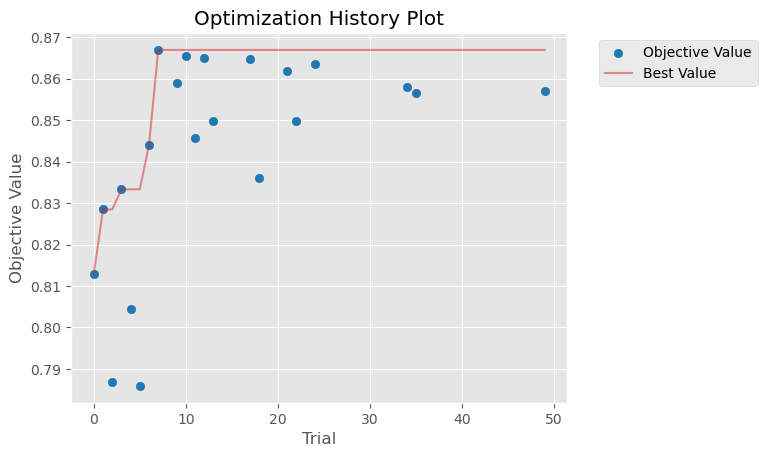

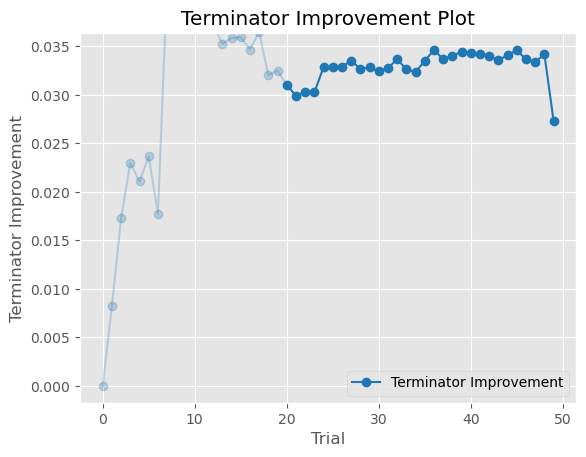

In [295]:
plot_optimization_history(studies[-1])
plot_terminator_improvement(studies[-1])

It appears that trial 7 brings the best score, however, we could have continued study, and maybe increase number of epochs. 

## Final model

### Constructing final model

For final model, we will define class CNN, which represents Convolutional Neural Network:

In [296]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            # 1x32x32 => 32x32x32
            nn.Conv2d(in_channels=1,
                      out_channels=32,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.SELU(),
            # 32x32x32 => 32x16x16
            nn.MaxPool2d(kernel_size=2,
                         stride=2,
                         padding=0)
        )
        
        self.layer2 = nn.Sequential(
            # 32x16x16 => 64x16x16
            nn.Conv2d(in_channels=32,
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.SELU(),
            # 64x16x16 => 64x8x8
            nn.MaxPool2d(kernel_size=2,
                         stride=2,
                         padding=0)
        )
        
        self.drop = nn.Dropout2d(0.3075445190855955)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(in_features=64*8*8, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=CLASSES)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.drop(out)
        out = self.flat(out)
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out

In [297]:
model = FashionCNN()
model.to(DEVICE)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): SELU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): SELU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop): Dropout2d(p=0.3075445190855955, inplace=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

Optimzer is Adam, with L2 regularization:

In [298]:
optimizer = optim.Adam(model.parameters(), lr=0.00012418433501935563, weight_decay=1.6252834003185993e-05)

And Loss function is CrossEntropy:

In [299]:
loss_fn = torch.nn.CrossEntropyLoss()

Now wew will train the model:

In [319]:
from tqdm import tqdm

EPOCHS = 30
epochs = []
train_loss = []
validation_loss = []
best_vloss = 1000000.

for epoch in range(EPOCHS):
    running_cum_loss = 0.
    print('EPOCH {}:'.format(epoch + 1))

    # Indicate training phase - important for dropout
    model.train(True)
    
    # One training step
    for data in tqdm(train_loader, total=len(train_loader)):
      inputs, labels = data
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)
      loss.backward()
      optimizer.step()
      # Gather data and report
      last_mean_loss = loss.item()
      running_cum_loss += last_mean_loss * inputs.shape[0]
        
    # the average over the whole training set
    avg_loss = running_cum_loss / len(train_data)

    # Indicate evaluation phase - important for dropout
    model.train(False)

    # Validation performance
    running_cum_vloss = 0.0
    vcorrect = 0
    for i, vdata in enumerate(val_loader):
        vinputs, vlabels = vdata
        with torch.no_grad():
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
        running_cum_vloss += vloss * vinputs.shape[0]
        # count the correctly classified samples
        vcorrect += (voutputs.argmax(1) == vlabels).float().sum()
    # Get average loss and accuraccy
    avg_vloss = running_cum_vloss / len(val_data)
    vacc = vcorrect / len(val_data)
    
    # collect values
    epochs.append(epoch)
    validation_loss.append(avg_vloss)
    train_loss.append(avg_loss)
    
    # Report progress
    print(f"TRAIN loss: {avg_loss:.3f}, VALIDATION loss: {avg_vloss:.3f}, accuraccy: {vacc:.3f}")
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        print("Saving best model")
        best_vloss = avg_vloss
        model_path = "saves/best_model2.pt"
        torch.save(model.state_dict(), model_path)
    else:
        print("No improvement in this epoch.")    

EPOCH 1:


100%|██████████| 247/247 [00:47<00:00,  5.19it/s]


TRAIN loss: 0.350, VALIDATION loss: 0.459, accuraccy: 0.855
Saving best model
EPOCH 2:


100%|██████████| 247/247 [00:47<00:00,  5.19it/s]


TRAIN loss: 0.344, VALIDATION loss: 0.381, accuraccy: 0.869
Saving best model
EPOCH 3:


100%|██████████| 247/247 [00:47<00:00,  5.24it/s]


TRAIN loss: 0.322, VALIDATION loss: 0.395, accuraccy: 0.868
No improvement in this epoch.
EPOCH 4:


100%|██████████| 247/247 [00:47<00:00,  5.20it/s]


TRAIN loss: 0.313, VALIDATION loss: 0.374, accuraccy: 0.873
Saving best model
EPOCH 5:


100%|██████████| 247/247 [00:47<00:00,  5.22it/s]


TRAIN loss: 0.299, VALIDATION loss: 0.392, accuraccy: 0.864
No improvement in this epoch.
EPOCH 6:


100%|██████████| 247/247 [00:47<00:00,  5.17it/s]


TRAIN loss: 0.298, VALIDATION loss: 0.385, accuraccy: 0.872
No improvement in this epoch.
EPOCH 7:


100%|██████████| 247/247 [00:46<00:00,  5.26it/s]


TRAIN loss: 0.290, VALIDATION loss: 0.373, accuraccy: 0.877
Saving best model
EPOCH 8:


100%|██████████| 247/247 [00:47<00:00,  5.24it/s]


TRAIN loss: 0.293, VALIDATION loss: 0.377, accuraccy: 0.870
No improvement in this epoch.
EPOCH 9:


100%|██████████| 247/247 [00:47<00:00,  5.25it/s]


TRAIN loss: 0.274, VALIDATION loss: 0.393, accuraccy: 0.869
No improvement in this epoch.
EPOCH 10:


100%|██████████| 247/247 [00:46<00:00,  5.35it/s]


TRAIN loss: 0.265, VALIDATION loss: 0.383, accuraccy: 0.869
No improvement in this epoch.
EPOCH 11:


100%|██████████| 247/247 [00:46<00:00,  5.32it/s]


TRAIN loss: 0.259, VALIDATION loss: 0.380, accuraccy: 0.873
No improvement in this epoch.
EPOCH 12:


100%|██████████| 247/247 [00:46<00:00,  5.32it/s]


TRAIN loss: 0.259, VALIDATION loss: 0.368, accuraccy: 0.878
Saving best model
EPOCH 13:


100%|██████████| 247/247 [00:46<00:00,  5.30it/s]


TRAIN loss: 0.248, VALIDATION loss: 0.397, accuraccy: 0.870
No improvement in this epoch.
EPOCH 14:


100%|██████████| 247/247 [00:46<00:00,  5.31it/s]


TRAIN loss: 0.249, VALIDATION loss: 0.393, accuraccy: 0.872
No improvement in this epoch.
EPOCH 15:


100%|██████████| 247/247 [00:46<00:00,  5.35it/s]


TRAIN loss: 0.243, VALIDATION loss: 0.384, accuraccy: 0.879
No improvement in this epoch.
EPOCH 16:


100%|██████████| 247/247 [00:46<00:00,  5.37it/s]


TRAIN loss: 0.243, VALIDATION loss: 0.377, accuraccy: 0.880
No improvement in this epoch.
EPOCH 17:


100%|██████████| 247/247 [00:46<00:00,  5.34it/s]


TRAIN loss: 0.235, VALIDATION loss: 0.395, accuraccy: 0.876
No improvement in this epoch.
EPOCH 18:


100%|██████████| 247/247 [00:46<00:00,  5.27it/s]


TRAIN loss: 0.226, VALIDATION loss: 0.389, accuraccy: 0.876
No improvement in this epoch.
EPOCH 19:


100%|██████████| 247/247 [00:45<00:00,  5.39it/s]


TRAIN loss: 0.225, VALIDATION loss: 0.387, accuraccy: 0.876
No improvement in this epoch.
EPOCH 20:


100%|██████████| 247/247 [00:45<00:00,  5.39it/s]


TRAIN loss: 0.229, VALIDATION loss: 0.391, accuraccy: 0.877
No improvement in this epoch.
EPOCH 21:


100%|██████████| 247/247 [00:46<00:00,  5.36it/s]


TRAIN loss: 0.222, VALIDATION loss: 0.392, accuraccy: 0.877
No improvement in this epoch.
EPOCH 22:


100%|██████████| 247/247 [00:48<00:00,  5.07it/s]


TRAIN loss: 0.216, VALIDATION loss: 0.375, accuraccy: 0.880
No improvement in this epoch.
EPOCH 23:


100%|██████████| 247/247 [00:45<00:00,  5.40it/s]


TRAIN loss: 0.216, VALIDATION loss: 0.393, accuraccy: 0.879
No improvement in this epoch.
EPOCH 24:


100%|██████████| 247/247 [00:46<00:00,  5.30it/s]


TRAIN loss: 0.210, VALIDATION loss: 0.381, accuraccy: 0.877
No improvement in this epoch.
EPOCH 25:


100%|██████████| 247/247 [00:45<00:00,  5.40it/s]


TRAIN loss: 0.202, VALIDATION loss: 0.406, accuraccy: 0.873
No improvement in this epoch.
EPOCH 26:


100%|██████████| 247/247 [00:45<00:00,  5.39it/s]


TRAIN loss: 0.208, VALIDATION loss: 0.410, accuraccy: 0.873
No improvement in this epoch.
EPOCH 27:


100%|██████████| 247/247 [00:45<00:00,  5.43it/s]


TRAIN loss: 0.201, VALIDATION loss: 0.408, accuraccy: 0.877
No improvement in this epoch.
EPOCH 28:


100%|██████████| 247/247 [00:46<00:00,  5.32it/s]


TRAIN loss: 0.200, VALIDATION loss: 0.395, accuraccy: 0.879
No improvement in this epoch.
EPOCH 29:


100%|██████████| 247/247 [00:46<00:00,  5.37it/s]


TRAIN loss: 0.201, VALIDATION loss: 0.445, accuraccy: 0.864
No improvement in this epoch.
EPOCH 30:


100%|██████████| 247/247 [00:45<00:00,  5.37it/s]


TRAIN loss: 0.202, VALIDATION loss: 0.404, accuraccy: 0.875
No improvement in this epoch.


Let's visualize train and validation losses:

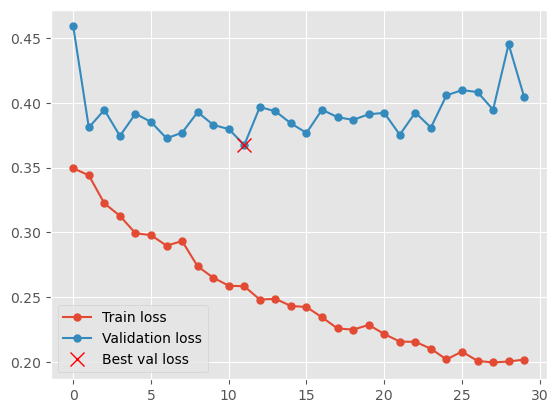

In [320]:
epochs = np.array(epochs)
validation_loss = np.array(validation_loss)
plt.plot(epochs,train_loss, '.-', markersize = 10, label='Train loss')
plt.plot(epochs,validation_loss, '.-', markersize = 10, label='Validation loss')
plt.plot([epochs[np.argmin(validation_loss)]], [validation_loss[np.argmin(validation_loss)]],'x', color = 'red', markersize = 10, label='Best val loss')
plt.legend()
plt.show()

### Model evaluation

Now we are ready to evaluate our model:

In [336]:
model_path = "saves/best_model2.pt"
# načteme nejlepší model
model.load_state_dict(torch.load(model_path))

test_predictions = np.zeros(len(test_dataset))
test_y = np.zeros(len(test_dataset))
print(test_predictions.shape)

ii = 0
for vdata in tqdm(test_loader):
    vinputs, vlabels = vdata
    with torch.no_grad():
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
    test_predictions[ii:(ii + vinputs.shape[0])] = voutputs.argmax(1).numpy()
    test_y[ii:(ii + vinputs.shape[0])] = vlabels.numpy()
    ii += vinputs.shape[0]
    
print(f"Testovací přesnost: {metrics.accuracy_score(test_y, test_predictions)}")

(10500,)


100%|██████████| 83/83 [00:06<00:00, 13.55it/s]

Testovací přesnost: 0.8751428571428571


#### Confusion matrix and major metrics:

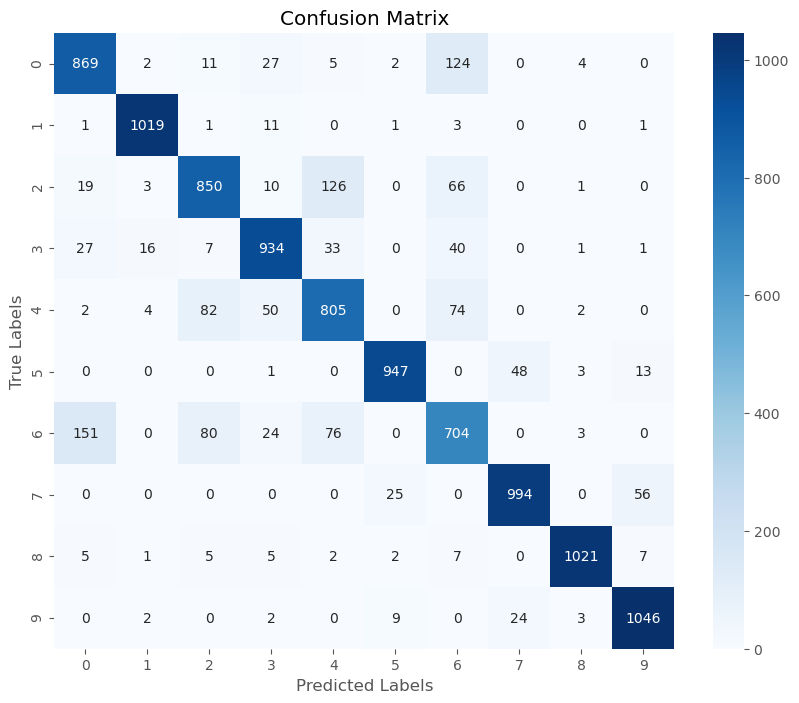

              precision    recall  f1-score   support

         0.0       0.81      0.83      0.82      1044
         1.0       0.97      0.98      0.98      1037
         2.0       0.82      0.79      0.81      1075
         3.0       0.88      0.88      0.88      1059
         4.0       0.77      0.79      0.78      1019
         5.0       0.96      0.94      0.95      1012
         6.0       0.69      0.68      0.68      1038
         7.0       0.93      0.92      0.93      1075
         8.0       0.98      0.97      0.98      1055
         9.0       0.93      0.96      0.95      1086

    accuracy                           0.88     10500
   macro avg       0.87      0.87      0.87     10500
weighted avg       0.88      0.88      0.88     10500



In [341]:
# Generate the confusion matrix
cm = metrics.confusion_matrix(ytest, test_predictions)

# Display the confusion matrix
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

class_report = metrics.classification_report(test_y, test_predictions)
print(class_report)

The model seems to be very good at predicting whether image is a Trouser, Sandal, Sneaker, Bag or a Ankle boot(labels 1,5,7,8,9). 
* Recall and precision for this labels are high, meaning if model predicts an image to be one of those clothes items, it almost likely to be true.

Prediction accuracy of labels 6 and 4 (Shirt and Coat) is to be questioned - it may be inaccurate

From confusion matrix, it is obvious that model can confuse T-shirt/top with Shirt and vise-versa.
* Shirt is the most difficult label to detect correctly, it is often misinterpret as Coat, Dress, Pullover or T-shirt/top